In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os 
import re
import time

import urllib.request
import h5py
import gzip
import pickle

from scipy import interpolate
import math

In [3]:
# Download data from ftps server
dir_dataraw = 'data/original'
dir_datastore='data/results'

In [4]:
worm_files = np.load(os.path.join(dir_dataraw,'N2_nine_worms.npz'))['files']

In [5]:
worm_files

array(['N2/on_food/XX/30m_wait/R/tracker_3/2010-11-04___11_16_00/N2 on food L_2010_11_04__11_16___3___3_features.mat',
       'N2/on_food/XX/30m_wait/R/tracker_3/2010-10-15___11_45_00/N2 on food L_2010_10_15__11_45___3___3_features.mat',
       'N2/on_food/XX/30m_wait/R/tracker_2/2011-04-13___11_19_12/N2 on food L_2011_04_13__11_19_12___2___3_features.mat',
       'N2/on_food/XX/30m_wait/R/tracker_2/2011-03-24___12_42_49/N2 on food_2011_03_24__12_42_49___2___2_features.mat',
       'N2/on_food/XX/30m_wait/R/tracker_2/2010-10-15___14_57_14/N2 on food L_2010_10_15__14_57_14___2___8_features.mat',
       'N2/on_food/XX/30m_wait/R/tracker_2/2010-10-15___13_03_39/N2 on food L_2010_10_15__13_03_39___2___7_features.mat',
       'N2/on_food/XX/30m_wait/R/tracker_2/2010-10-15___12_25_23/N2 on food L_2010_10_15__12_25_23___2___5_features.mat',
       'N2/on_food/XX/30m_wait/R/tracker_2/2010-10-15___11_25_26/N2 on food L_2010_10_15__11_25_26___2___2_features.mat',
       'N2/on_food/XX/30m_wait/R

In [6]:
# datasouce path
ftp_path='ftp://ftp.mrc-lmb.cam.ac.uk/pub/tjucikas/wormdatabase/results-12-06-08/Laura%20Grundy/gene_NA/allele_NA/'

In [7]:
# Download original worm files
for line in worm_files:
    src_path = os.path.join(ftp_path, line)
    dest_path = os.path.join(dir_dataraw,line)
    if os.path.exists(dest_path):
        print('File exists\n{}\n'.format(dest_path))
    else:
        print('File "%s" is not in memory\n'%line)
        tmp_ = os.path.join(dir_dataraw,os.path.dirname(line))
        if not os.path.exists(tmp_):
            print('Creating directory\n')
            os.makedirs(tmp_)
        print("Downloading to %s"%dest_path)
        urllib.request.urlretrieve(src_path, dest_path)

File exists
data/original/N2/on_food/XX/30m_wait/R/tracker_3/2010-11-04___11_16_00/N2 on food L_2010_11_04__11_16___3___3_features.mat

File exists
data/original/N2/on_food/XX/30m_wait/R/tracker_3/2010-10-15___11_45_00/N2 on food L_2010_10_15__11_45___3___3_features.mat

File exists
data/original/N2/on_food/XX/30m_wait/R/tracker_2/2011-04-13___11_19_12/N2 on food L_2011_04_13__11_19_12___2___3_features.mat

File exists
data/original/N2/on_food/XX/30m_wait/R/tracker_2/2011-03-24___12_42_49/N2 on food_2011_03_24__12_42_49___2___2_features.mat

File exists
data/original/N2/on_food/XX/30m_wait/R/tracker_2/2010-10-15___14_57_14/N2 on food L_2010_10_15__14_57_14___2___8_features.mat

File exists
data/original/N2/on_food/XX/30m_wait/R/tracker_2/2010-10-15___13_03_39/N2 on food L_2010_10_15__13_03_39___2___7_features.mat

File exists
data/original/N2/on_food/XX/30m_wait/R/tracker_2/2010-10-15___12_25_23/N2 on food L_2010_10_15__12_25_23___2___5_features.mat

File exists
data/original/N2/on_foo

In [8]:
def XY_resample(X, Y):
    """
    Resample X,Y such that
    all samples are equally spaced and
    first order derivative (arc) is continuous
    """
    dim1, dim2 = X.shape
    Xi = np.zeros(shape=(dim1, dim2), dtype=float) * np.nan
    Yi = np.zeros(shape=(dim1, dim2), dtype=float) * np.nan

    # Interpolate st dx is continuous
    for ii in range(0, dim2):
        if ii % 1000 == 0:
            print('Interpolating sample %d'%ii)
        if ~np.isnan(X[0, ii]):
            dx = np.diff(X[:, ii])
            dy = np.diff(Y[:, ii])
            dxy = np.append(0, dx ** 2 + dy ** 2)
            t = np.cumsum(np.sqrt(dxy))
            # equally spaced sampling
            ti = np.linspace(t[0], t[-1], dim1)
            f = interpolate.PchipInterpolator(t, X[:, ii])
            Xi[:, ii] = f(ti)
            f = interpolate.PchipInterpolator(t, Y[:, ii])
            Yi[:, ii] = f(ti)
    return Xi, Yi

In [9]:
def eigenAmps_clean(eigenAmps):
    """
    Remove leading/trailing NaNs
    """
    if np.isnan(eigenAmps[0,0]):
        # get the end of the starting NaN segment
        afternan = np.where(np.isnan(eigenAmps))[0][-1] + 1
        np.where(eigenAmps[afternan:] == 1)[0][0]
        # drop these values
        eigenAmps[:, 0:nanEnd] = [];
    if np.isnan(eigenAmps[0, -1]):
        # get the start of the final NaN segment
        nanVals =np.where(np.isnan(eigenAmps[0, :]))[0]
        nanStart = np.where(np.diff(nanVals)!=1)[0][-1] + 1
        # drop these values
        eigenAmps[:, nanStart:] = []
    # linearly interpolate over missing values
    eigenAmpsNoNaN = nan_interpolate(eigenAmps)
    return eigenAmpsNoNaN

In [10]:
def worm_covariance(angleArray):
    """
    Calculate covariance
    where eigenvecs are the columns
    """
    ### Select timeframes (angles) without nan
    omit_rows = np.isnan(angleArray).sum(1)
    print('Skipping %d angles'%(np.sum(omit_rows>1)))
    angleArrayNoNaN = angleArray[omit_rows<1,:]
    C = np.cov(angleArrayNoNaN.T)
    #plt.imshow(C,cmap='viridis')
    eigval, eigvec = np.linalg.eig(C)
    idx = eigval.argsort()[::-1]
    eigval = eigval[idx]
    eigvec = eigvec[:,idx]
    return eigval,eigvec

In [11]:
def resample_data(fpath,X,Y,fname_xyresampled='xy_resampled.npz'):
    """
    Resample X,Y
    """
    if not os.path.isdir(fpath):
        os.mkdir(fpath)

    fpath = os.path.join(fpath,fname_xyresampled)
    if os.path.exists(fpath):
        print('\nLoading resampled data from {}'.format(fpath))
        Xi = np.load(fpath)['Xi']
        Yi = np.load(fpath)['Yi']
    else:
        t0 = time.time()
        Xi,Yi = XY_resample(X,Y)
        t1 = time.time()
        print('Run time of {}'.format(t1-t0))
        print('\nStoring resampled data as %s'%(fpath))
        np.savez(fpath,Xi=Xi,Yi=Yi)
    return Xi, Yi


In [12]:
def nan_interpolate(Xi):
    """
    Linearly interpolate missing (NaN) frames
    """
    X = Xi.copy()
    dim1, dim2 = X.shape
    Xout = np.zeros(shape=(dim1, dim2), dtype=float) * np.nan
    t = np.arange(dim2)
    for ii in range(0, dim1):
        xi = X[ii, :]
        nanx = np.where(np.isnan(xi))
        nnanx = np.where(~np.isnan(xi))
        xi[nanx] = np.interp(t[nanx], t[nnanx], xi[nnanx])
        Xout[ii, :] = xi
    return Xout

In [13]:
def get_arc2angle(x, y):
    """
    Calculate angle between x,y coordinates
    """
    dx = np.diff(x, axis=1)
    dy = np.diff(y, axis=1)
    # account for discontinuity
    angles = list(map(np.arctan2, dy, dx))
    angles = np.unwrap(angles, axis=1)
    #rotate angles st mean orientation is zero
    meanAngle = angles.mean(1, keepdims=True)
    AngleArray = angles - meanAngle
    return AngleArray, meanAngle

In [14]:
def eig_normalization(eigenworms):
    """
    Estimator of the second moment : for mean = 0, var = 1
    """
    norm_eworms = (eigenworms-eigenworms.mean(1, keepdims=True)) \
        / eigenworms.std(1, keepdims=True)
    return norm_eworms

In [15]:
def extract_worm(fname_in, fname_dout,store_en=True,
        fname_pdata='pdata.npz'):
    """
    Extract activity of single worm
    """
    # check if file exists:
    if os.path.isfile(os.path.join(fname_dout,fname_pdata)):
        print('File\n{}\nalready exists!\n'.format(
            os.path.join(fname_dout,fname_pdata)))
        au = np.load(os.path.join(fname_dout,fname_pdata))['au']
        return au

    print('\n File does not exist\n')
    print('Loading data {}'.format(fname_in))
    f = h5py.File(fname_in,'r')

    # Get worm posture and length
    X = f['worm']['posture']['skeleton']['x'][()].T
    Y = f['worm']['posture']['skeleton']['y'][()].T
    meanL = np.nanmean(f['worm']['morphology']['length'])

    # Resample data and normalize wrt length
    Xi,Yi = resample_data(fname_dout,X,Y)
    Xi, Yi =Xi/meanL , Yi/meanL

    # Interpolate each position
    if True:
        x = nan_interpolate(Yi)
        y = nan_interpolate(Xi)
    else:
        x , y = Xi, Yi

    # Get angle from x,y coordinates (zero mean angle)
    angleArray, meanAngles = get_arc2angle(x.T,y.T)
    # Rotate worm wrt ventral vs dorsal (invert all angles)
    if '--L_--' in fname_dout:
        angleArray = angleArray*-1

    # Apply PCA to angle covariance
    eigval, eigvec = worm_covariance(angleArray)

    # Calculate amplitudes of motion along PCs
    # Projections of worm shape (angle) onto the low dim space of eigenworms
    eigenAmps = np.dot(eigvec.T,angleArray.T)

    # Remove nans and normalize
    eigenAmpsNoNaN = eigenAmps_clean(eigenAmps)
    au = eig_normalization(eigenAmpsNoNaN)

    if store_en:
        np.savez(os.path.join(fname_dout,fname_pdata),
                au=au, eigval=eigval,x=x, y=y,
                eigvec=eigvec, angleArray=angleArray,
                meanAngles=meanAngles,
                eigenAmpsNoNaN=eigenAmpsNoNaN)
    return  au

In [16]:
# directory to store data
fout = os.path.join(dir_datastore,'extracted_aus_N2.npz')
if not os.path.isfile(fout):
    aus , lens = [], []
    for ii , worm_file in enumerate(worm_files):
        fname_in = os.path.join(dir_dataraw, worm_file)
        fname_out = os.path.join(dir_datastore,
                                 re.sub('/','--',worm_file.strip())[:-4])
        os.makedirs(fname_out)
        print('Processing %s'%(fname_in))
        au = extract_worm(fname_in,fname_out)
        aus.append(au)
        lens.append(au.shape[1])
    np.savez(fout,aus=np.concatenate(aus,axis=1),
             worm_files=worm_files,
             time_frames=lens)
else:
    print('File "%s" exits'%fout) 

File "data/results/extracted_aus_N2.npz" exits


In [17]:
fname_pdata = 'pdata.npz'
all_angleArray= [np.load(os.path.join(dir_datastore,
                                          re.sub('/', '--',worm_file[:-4]),
                                          fname_pdata))['angleArray'] 
                     for worm_file in worm_files]

In [18]:
all_angleArray[0].shape

(26994, 48)

In [19]:
def make_joint_aus(worm_files,dir_datastore):
    """
    Combine activity of selected worms
    """
    fout_eig = os.path.join(dir_datastore,'joint_eigAmps_N2.npz')
    fout_aus = os.path.join(dir_datastore,'joint_aus_N2.npz')
    
    if os.path.exists(fout_aus):
        aus = np.asarray(np.load(fout_aus)['aus'])
        eigvec_all = np.load(fout_aus)['eigvecs']
        dims = aus.shape
        aus = aus.reshape((np.prod(dims[:2]),-1))
        return aus, eigvec_all
    
    fname_pdata = 'pdata.npz'
    all_angleArray= [np.load(os.path.join(dir_datastore,
                                          re.sub('/', '--',worm_file[:-4]),
                                          fname_pdata))['angleArray'] 
                     for worm_file in worm_files]

    # force angles to have same length
    common_ = min([np.shape(x)[0] for x in all_angleArray])
    time_frames = [common_]*len(worm_files)
    locations = np.cumsum(time_frames[:-1])
    worms_angleArray = [angle[:common_,:] for angle in all_angleArray]
    worms_angleArray = np.vstack(worms_angleArray)
    eigval_all, eigvec_all = worm_covariance(worms_angleArray)
    eigAmps = np.dot(eigvec_all.T,worms_angleArray.T)
    eigAmps_list = np.hsplit(eigAmps,locations)
    np.savez(fout_eig,eigAmps=eigAmps_list,
         worm_files=worm_files,
         time_frames=time_frames)

    au = eig_normalization(eigAmps)
    au_list = np.hsplit(au,locations)

    np.savez(fout_aus, aus=au_list,
             worm_files=worm_files,
             time_frames=time_frames,
             eigvecs=eigvec_all)
    return au, eigvec_all 

In [20]:
def fig1a_pc(eigvec_all):
    """
    plot eigvecs
    """
    num_eigs , num_pts = eigvec_all.shape
    num_eigs=4
    s = np.linspace(0,1,num_pts)
    fig, axarr = plt.subplots(num_eigs,1,figsize=(4,8))
    for ii in range(num_eigs):
        axarr[ii].plot(s,eigvec_all[:,ii],'k')
        axarr[ii].plot(s,np.zeros(num_pts),'r-')
        axarr[ii].plot(np.zeros(num_pts),
                       np.linspace(-0.05,0.2,num_pts),'r-')
        axarr[ii].set_axis_off()
    plt.show()
    return

In [21]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['text.latex.unicode'] = True

from itertools import combinations,product


In [22]:
def fig1a_jd(au):
    """
    Plot joint pd of au values
    """
    #from matplotlib import rc, rcParams
    import matplotlib
    from mpl_toolkits.axes_grid1 import AxesGrid
    #plt.rc('text', usetex=True)
    #plt.rc('font', family='times')
    #rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
    #matplotlib.rcParams.update({'font.size': 10})
       
    fig = plt.figure(figsize=(4, 6))
    grid = AxesGrid(fig, 111,
                direction='column',
                nrows_ncols=(3, 2),
                axes_pad=0.55,
                share_all=False,
                label_mode=all,
                cbar_location='bottom',
                cbar_mode='single',
                cbar_pad=0.00,
                )

    bins = np.linspace(-2, 2, 101)
    tick_vals= np.linspace(-2,2,3)

    for index, pairs in enumerate(combinations(np.arange(4),2)):
        pc1, pc2 = pairs    
        H, _, _= np.histogram2d(au[pc1],au[pc2],
                                normed=True,bins=bins)
        ax = grid[index] 
        img = ax.imshow(H, interpolation='nearest', 
                        clim=(0.0, 0.3) , 
                        extent=[-2, 2, -2, 2] ,
                        cmap='Reds',vmin=0,vmax=0.3)
        ax.set_xticks(tick_vals)
        ax.set_yticks(tick_vals)
        ax.set_xticklabels(map(str,tick_vals))
        ax.set_yticklabels(map(str,tick_vals))
        ax.set_aspect('equal')
        ax.set_xlabel(r'$a_{%d}$'%(pc1+1))
        ax.set_ylabel(r'$a_{%d}$'%(pc2+1))
    cbar = grid.cbar_axes[0].colorbar(img)
    cbar.ax.set_xticks(np.linspace(0,0.3,3))
    
    plt.subplots_adjust(hspace=0.3)
    plt.show()
    #plt.savefig('figures/all_aus_reds.eps')
    return

In [23]:
au, eigvec_all= make_joint_aus(worm_files,dir_datastore)

In [24]:
## fig1a_jd(au)

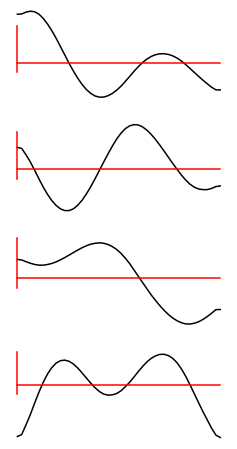

In [25]:
fig1a_pc(eigvec_all)

In [26]:
from collections import namedtuple

Results = namedtuple( "Results", 
                     ["name", "loglikes", "predictive_lls",
                      "predictive_lls2","N_used", "alphas",
                      "gammas","samples", "timestamps"])

def load_batch_results(fdir,attribute,worm_array,
                       state_array,alpha_array,gamma_array,kappa_array):
    cresults =[]
    for worm , num_states, alpha_a_0, gamma_a_0, kappa_a_0 in product(
        worm_array, state_array,alpha_array,gamma_array,kappa_array):
        fname = "ar_scale_worm%s_states%s_alpha%s_gamma%s_kappa%s"%(
            worm,"%.1f" %num_states, "%.1f" %alpha_a_0, "%.1f" %gamma_a_0,
            "%.1f" %kappa_a_0)
        results_file = os.path.join(fdir,fname + ".pkl.gz")
        with gzip.open(results_file, "r") as f:
            results = pickle.load(f)
            out = getattr(results,attribute)
            if not (attribute =='samples'):
                cresults.append(np.asarray(out))
            else:
                cresults.append(out)
    if not (attribute =='samples'):
        cresults = np.asarray(cresults)
    return cresults

In [27]:
# experiments_out = os.path.join(dir_datastore,'run010')
worm_files_ = [re.sub('/', '--',worm_file[:-4]) for worm_file in worm_files]
fname_pdata = 'pdata.npz'

In [28]:
# Load info from each worm
all_angleArray= [np.load(os.path.join(
    dir_datastore,worm_file,fname_pdata))['angleArray'] 
                 for worm_file in worm_files_]
all_meanAngle= [np.load(os.path.join(
    dir_datastore,worm_file,fname_pdata))['meanAngles'] 
                 for worm_file in worm_files_]
all_x= [np.load(os.path.join(
    dir_datastore,worm_file,fname_pdata))['x'] 
                 for worm_file in worm_files_]
all_y= [np.load(os.path.join(
    dir_datastore,worm_file,fname_pdata))['y'] 
                 for worm_file in worm_files_]

In [29]:
def fig1a_plane(x,y,tf=4500):
    plt.plot(x[0,:],y[0,:],'k')
    plt.plot(x[0,tf],y[0,tf],'ro',ms=10)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    return
#plt.savefig('figures/worm_xyplot.eps', format='eps',orientation='portrait',papertype='letter')

def fig1a_cworm(x,tf):
    plt.plot(x[tf],'k',lw=3)
    plt.plot(x[tf,0],'ro')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    return
#plt.savefig('figures/worm_angleArray.eps', format='eps',orientation='portrait',papertype='letter')

In [30]:
worm_idx = 2

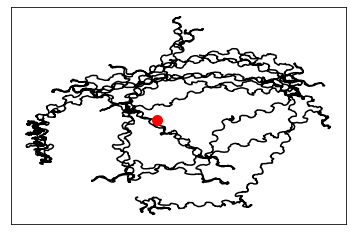

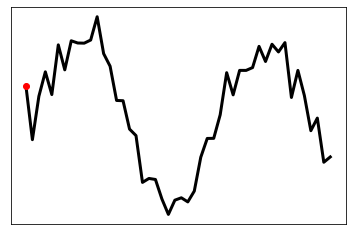

In [31]:
aa = all_x[worm_idx]
bb = all_y[worm_idx]
cc = all_angleArray[worm_idx]
fig1a_plane(aa,bb)
fig1a_cworm(cc,26994)

In [32]:
cc[26994]

array([ 0.15149266, -0.2397332 ,  0.075196  ,  0.25296095,  0.08777943,
        0.44880512,  0.2673191 ,  0.47836854,  0.46226375,  0.46107924,
        0.48378139,  0.65291684,  0.38516077,  0.29366977,  0.04506635,
        0.04308352, -0.16273148, -0.21017048, -0.54994218, -0.52122256,
       -0.52863594, -0.6704048 , -0.78240918, -0.67900349, -0.66167248,
       -0.691474  , -0.61306259, -0.36736824, -0.23074319, -0.23005271,
       -0.05884158,  0.24677271,  0.08569636,  0.26338986,  0.26330947,
        0.28377063,  0.43779437,  0.32810862,  0.45321141,  0.39735757,
        0.464928  ,  0.06668268,  0.26324773,  0.08036908, -0.17446649,
       -0.08300142, -0.4036706 , -0.36497534])

In [33]:
def load_data(fpath, num_pcs=4,trainfrac=0.8):
    """
    Load aus from fpath
    """
    data_sets = np.load(fpath)['aus']
    time_frames = np.load(fpath)['time_frames']
    number_datasets = len(time_frames)

    shortest_data   = min(time_frames)
    train_frames    = int(trainfrac*shortest_data)
    train_data, test_data = [] , []
    for data in data_sets:
        train_data.append(data[:num_pcs,:train_frames].T)
        test_data.append(data[:num_pcs,train_frames:shortest_data].T)
    return train_data, test_data

In [34]:
dir_result='data/results/'
work_dir = os.path.join(os.getcwd(), dir_result)
file_in =  os.path.join(work_dir,'joint_aus_N2.npz')

train_data , test_data = load_data(file_in)

In [35]:
num_worms = len(train_data)
print('Number of files: %d'%(num_worms))
print ("T_train: %d"%(train_data[0].shape[0]))
print ("T_test: %d"%(test_data[0].shape[0]))

Number of files: 9
T_train: 21595
T_test: 5399


In [36]:
train_data[0].shape

(21595, 4)

In [37]:
test_data[0].shape[1]

4

In [38]:
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Flatten

In [39]:
from matplotlib import pyplot as plt

In [40]:
class MultiInputModels:
    '''
    单变量时间序列LSTM模型
    '''
    def __init__(self, train_seq, test_seq, sw_width, epochs_num, verbose_set): 
        '''
        初始化变量和参数
        '''
        self.train_seq = train_seq
        self.test_seq = test_seq
        self.sw_width = sw_width
        
        self.epochs_num = epochs_num
        self.verbose_set = verbose_set
        
        self.X, self.y = [], []    
        
    
    def split_sequence_parallel(self):
        '''
        该函数实现多输入序列数据的样本划分
        '''
        for i in range(len(self.train_seq)):
            # 找到最后一个元素的索引，因为for循环中i从1开始，切片索引从0开始，切片区间前闭后开，所以不用减去1；
            end_index = i + self.sw_width
            # 如果最后一个滑动窗口中的最后一个元素的索引大于序列中最后一个元素的索引则丢弃该样本；
            # 这里len(self.sequence)减去1的原因是：保证最后一个元素的索引恰好等于序列数据索引时，能够截取到样本；
            if end_index > len(self.train_seq) - 1:
                break
                
            # 实现以滑动步长为1（因为是for循环），窗口宽度为self.sw_width的滑动步长取值；
            # [i:end_index, :] 截取第i行到第end_index-1行、所有列的数据；
            # [end_index-1, :] 截取第end_index行、所有列的数据；
            seq_x, seq_y = self.train_seq[i:end_index, :], self.train_seq[end_index, :]
            self.X.append(seq_x)
            self.y.append(seq_y)
            
        self.X, self.y = np.array(self.X), np.array(self.y)
        self.features = self.X.shape[2]
        self.test_seq = self.test_seq.reshape((1, self.sw_width, self.test_seq.shape[0]))

        for i in range(len(self.X)):
            print(self.X[i], self.y[i])
        
        print('X:\n{}\ny:\n{}\ntest_seq:\n{}\n'.format(self.X, self.y, self.test_seq))
        print('X.shape:{}, y.shape:{}, test_seq.shape:{}\n'.format(self.X.shape, self.y.shape, self.test_seq.shape))
        
        return self.X, self.y, self.features, self.test_seq    
    
    def stacked_lstm(self):
        model = Sequential()
        model.add(LSTM(100, activation='relu', return_sequences=True, 
                       input_shape=(self.sw_width, self.features)))
        model.add(LSTM(100, activation='relu'))
        model.add(Dense(self.features))
        model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

        history = model.fit(self.X, self.y, epochs=self.epochs_num, verbose=self.verbose_set)
        
        self.acc = history.history['accuracy']
        self.loss = history.history['loss']
        
        print('\ntrain_acc:%s'%history.history['accuracy'], '\ntrain_loss:%s'%history.history['loss'])
        print('yhat:%s'%(model.predict(self.test_seq)),'\n-----------------------------')
        
        return self.acc, self.loss
        

In [42]:
if __name__ == '__main__':
    
    sw_width = 4
    epochs_num = 500
    verbose_set = 0
    
    print('-----------以下为 【多并行序列LSTM模型】 相关信息-----------------')
    MultiInputLSTM = MultiInputModels(train_data[0], test_data[0][0:4], sw_width, epochs_num, verbose_set)
    MultiInputLSTM.split_sequence_parallel()
    MultiInputLSTM.stacked_lstm()
    

-----------以下为 【多并行序列LSTM模型】 相关信息-----------------
[[ 1.25217833 -0.32695315 -1.18504344 -0.64235883]
 [ 1.25217833 -0.32695315 -1.18504344 -0.64235883]
 [ 1.25217833 -0.32695315 -1.18504344 -0.64235883]
 [ 1.25217833 -0.32695315 -1.18504344 -0.64235883]] [ 1.25217833 -0.32695315 -1.18504344 -0.64235883]
[[ 1.25217833 -0.32695315 -1.18504344 -0.64235883]
 [ 1.25217833 -0.32695315 -1.18504344 -0.64235883]
 [ 1.25217833 -0.32695315 -1.18504344 -0.64235883]
 [ 1.25217833 -0.32695315 -1.18504344 -0.64235883]] [ 1.25217833 -0.32695315 -1.18504344 -0.64235883]
[[ 1.25217833 -0.32695315 -1.18504344 -0.64235883]
 [ 1.25217833 -0.32695315 -1.18504344 -0.64235883]
 [ 1.25217833 -0.32695315 -1.18504344 -0.64235883]
 [ 1.25217833 -0.32695315 -1.18504344 -0.64235883]] [ 1.25217833 -0.32695315 -1.18504344 -0.64235883]
[[ 1.25217833 -0.32695315 -1.18504344 -0.64235883]
 [ 1.25217833 -0.32695315 -1.18504344 -0.64235883]
 [ 1.25217833 -0.32695315 -1.18504344 -0.64235883]
 [ 1.25217833 -0.32695315 -1.18

 [-1.22797652 -0.04210705  0.55061016 -0.23433207]] [-1.22820563  0.08983265  0.57203354 -0.29672985]
[[-1.2273373  -0.31190063  0.50737803 -0.10616143]
 [-1.22767893 -0.17644634  0.52905962 -0.17049251]
 [-1.22797652 -0.04210705  0.55061016 -0.23433207]
 [-1.22820563  0.08983265  0.57203354 -0.29672985]] [-1.23484695  0.1677083   0.54822452 -0.28392004]
[[-1.22767893 -0.17644634  0.52905962 -0.17049251]
 [-1.22797652 -0.04210705  0.55061016 -0.23433207]
 [-1.22820563  0.08983265  0.57203354 -0.29672985]
 [-1.23484695  0.1677083   0.54822452 -0.28392004]] [-1.29053672  0.21043691  0.53273537 -0.1699397 ]
[[-1.22797652 -0.04210705  0.55061016 -0.23433207]
 [-1.22820563  0.08983265  0.57203354 -0.29672985]
 [-1.23484695  0.1677083   0.54822452 -0.28392004]
 [-1.29053672  0.21043691  0.53273537 -0.1699397 ]] [-1.27724442  0.25797354  0.54153726 -0.07372999]
[[-1.22820563  0.08983265  0.57203354 -0.29672985]
 [-1.23484695  0.1677083   0.54822452 -0.28392004]
 [-1.29053672  0.21043691  0.53

 [-1.28783709 -0.32086201  0.09424571 -0.92642968]] [-1.24969008 -0.2078544   0.14190561 -0.94503661]
[[-1.35971282 -0.55065086 -0.01627334 -0.72881316]
 [-1.32492025 -0.43224123  0.04732867 -0.90713342]
 [-1.28783709 -0.32086201  0.09424571 -0.92642968]
 [-1.24969008 -0.2078544   0.14190561 -0.94503661]] [-1.21155654 -0.09487797  0.18950255 -0.96365677]
[[-1.32492025 -0.43224123  0.04732867 -0.90713342]
 [-1.28783709 -0.32086201  0.09424571 -0.92642968]
 [-1.24969008 -0.2078544   0.14190561 -0.94503661]
 [-1.21155654 -0.09487797  0.18950255 -0.96365677]] [-1.17450938  0.01640907  0.23624167 -0.98297508]
[[-1.28783709 -0.32086201  0.09424571 -0.92642968]
 [-1.24969008 -0.2078544   0.14190561 -0.94503661]
 [-1.21155654 -0.09487797  0.18950255 -0.96365677]
 [-1.17450938  0.01640907  0.23624167 -0.98297508]] [-1.12717297  0.09626203  0.26971083 -0.95369056]
[[-1.24969008 -0.2078544   0.14190561 -0.94503661]
 [-1.21155654 -0.09487797  0.18950255 -0.96365677]
 [-1.17450938  0.01640907  0.23

 [-1.48282177 -0.37995223  0.29226143 -0.23528847]] [-1.50827659 -0.30311242  0.29769963 -0.22633501]
[[-1.43307223 -0.71274855  0.19589208 -0.05083779]
 [-1.49403347 -0.53733198  0.22430607 -0.22404957]
 [-1.48282177 -0.37995223  0.29226143 -0.23528847]
 [-1.50827659 -0.30311242  0.29769963 -0.22633501]] [-1.50386284 -0.21964233  0.33311451 -0.25169004]
[[-1.49403347 -0.53733198  0.22430607 -0.22404957]
 [-1.48282177 -0.37995223  0.29226143 -0.23528847]
 [-1.50827659 -0.30311242  0.29769963 -0.22633501]
 [-1.50386284 -0.21964233  0.33311451 -0.25169004]] [-1.54014    -0.17143855  0.33331414 -0.13775861]
[[-1.48282177 -0.37995223  0.29226143 -0.23528847]
 [-1.50827659 -0.30311242  0.29769963 -0.22633501]
 [-1.50386284 -0.21964233  0.33311451 -0.25169004]
 [-1.54014    -0.17143855  0.33331414 -0.13775861]] [-1.49206374  0.00811515  0.3700691  -0.27399775]
[[-1.50827659 -0.30311242  0.29769963 -0.22633501]
 [-1.50386284 -0.21964233  0.33311451 -0.25169004]
 [-1.54014    -0.17143855  0.33

 [-1.11254523  0.09217717  0.91174019  0.42051567]] [-1.12008705 -0.13096972  0.89432091  0.30493615]
[[-1.06876909  0.39479743  0.89691414  0.57776781]
 [-1.07370085  0.24692388  0.9236955   0.49251447]
 [-1.11254523  0.09217717  0.91174019  0.42051567]
 [-1.12008705 -0.13096972  0.89432091  0.30493615]] [-1.14172281 -0.29745468  0.83806065  0.26524948]
[[-1.07370085  0.24692388  0.9236955   0.49251447]
 [-1.11254523  0.09217717  0.91174019  0.42051567]
 [-1.12008705 -0.13096972  0.89432091  0.30493615]
 [-1.14172281 -0.29745468  0.83806065  0.26524948]] [-1.09172214 -0.48680565  0.80348239  0.13873697]
[[-1.11254523  0.09217717  0.91174019  0.42051567]
 [-1.12008705 -0.13096972  0.89432091  0.30493615]
 [-1.14172281 -0.29745468  0.83806065  0.26524948]
 [-1.09172214 -0.48680565  0.80348239  0.13873697]] [-1.08941266 -0.68613575  0.69946925  0.01202721]
[[-1.12008705 -0.13096972  0.89432091  0.30493615]
 [-1.14172281 -0.29745468  0.83806065  0.26524948]
 [-1.09172214 -0.48680565  0.80

 [ 1.35459888 -0.31672903 -0.45463057  0.06978969]] [ 1.30373958 -0.43834176 -0.45299741  0.24789457]
[[ 1.50431144 -0.00932825 -0.40215597 -0.07884062]
 [ 1.45062775 -0.1150974  -0.41777552  0.0779508 ]
 [ 1.35459888 -0.31672903 -0.45463057  0.06978969]
 [ 1.30373958 -0.43834176 -0.45299741  0.24789457]] [ 1.18907137 -0.61649171 -0.45176321  0.44109997]
[[ 1.45062775 -0.1150974  -0.41777552  0.0779508 ]
 [ 1.35459888 -0.31672903 -0.45463057  0.06978969]
 [ 1.30373958 -0.43834176 -0.45299741  0.24789457]
 [ 1.18907137 -0.61649171 -0.45176321  0.44109997]] [ 1.09045003 -0.7192233  -0.45355401  0.54418988]
[[ 1.35459888 -0.31672903 -0.45463057  0.06978969]
 [ 1.30373958 -0.43834176 -0.45299741  0.24789457]
 [ 1.18907137 -0.61649171 -0.45176321  0.44109997]
 [ 1.09045003 -0.7192233  -0.45355401  0.54418988]] [ 1.02385058 -0.73903787 -0.47400412  0.55187012]
[[ 1.30373958 -0.43834176 -0.45299741  0.24789457]
 [ 1.18907137 -0.61649171 -0.45176321  0.44109997]
 [ 1.09045003 -0.7192233  -0.45

 [-2.03696963  0.30746297 -0.36008097  0.93079128]] [-2.01678271  0.45711655 -0.38984725  0.67457553]
[[-2.01526131  0.17923342 -0.34838382  1.00894649]
 [-2.01080339  0.20358472 -0.33682487  1.01940393]
 [-2.03696963  0.30746297 -0.36008097  0.93079128]
 [-2.01678271  0.45711655 -0.38984725  0.67457553]] [-1.99242254  0.51165461 -0.40058192  0.48486323]
[[-2.01080339  0.20358472 -0.33682487  1.01940393]
 [-2.03696963  0.30746297 -0.36008097  0.93079128]
 [-2.01678271  0.45711655 -0.38984725  0.67457553]
 [-1.99242254  0.51165461 -0.40058192  0.48486323]] [-1.94772216  0.60065503 -0.40806315  0.39898788]
[[-2.03696963  0.30746297 -0.36008097  0.93079128]
 [-2.01678271  0.45711655 -0.38984725  0.67457553]
 [-1.99242254  0.51165461 -0.40058192  0.48486323]
 [-1.94772216  0.60065503 -0.40806315  0.39898788]] [-1.90401367  0.68271801 -0.4141293   0.33248362]
[[-2.01678271  0.45711655 -0.38984725  0.67457553]
 [-1.99242254  0.51165461 -0.40058192  0.48486323]
 [-1.94772216  0.60065503 -0.40

 [-0.12345082 -0.62889423 -0.54993211  1.54451273]] [-0.27259524 -0.68041088 -0.57376906  1.5006326 ]
[[ 0.15054956 -0.50998853 -0.48787322  1.68227627]
 [ 0.02232629 -0.57848489 -0.52732313  1.58902672]
 [-0.12345082 -0.62889423 -0.54993211  1.54451273]
 [-0.27259524 -0.68041088 -0.57376906  1.5006326 ]] [-0.42192689 -0.73201684 -0.59764344  1.45659518]
[[ 0.02232629 -0.57848489 -0.52732313  1.58902672]
 [-0.12345082 -0.62889423 -0.54993211  1.54451273]
 [-0.27259524 -0.68041088 -0.57376906  1.5006326 ]
 [-0.42192689 -0.73201684 -0.59764344  1.45659518]] [-0.56825522 -0.78268561 -0.62035971  1.41162822]
[[-0.12345082 -0.62889423 -0.54993211  1.54451273]
 [-0.27259524 -0.68041088 -0.57376906  1.5006326 ]
 [-0.42192689 -0.73201684 -0.59764344  1.45659518]
 [-0.56825522 -0.78268561 -0.62035971  1.41162822]] [-0.6943747  -0.82739976 -0.64388143  1.31514888]
[[-0.27259524 -0.68041088 -0.57376906  1.5006326 ]
 [-0.42192689 -0.73201684 -0.59764344  1.45659518]
 [-0.56825522 -0.78268561 -0.62

 [ 1.30106608e+00 -1.29673822e-03  3.83210357e-01  8.94156420e-01]] [ 1.23250906 -0.10694087  0.34916647  0.97654069]
[[ 1.49058982e+00  3.54518292e-01  5.21535494e-01  3.76000919e-01]
 [ 1.41700079e+00  1.56922696e-01  4.46414444e-01  7.25298524e-01]
 [ 1.30106608e+00 -1.29673822e-03  3.83210357e-01  8.94156420e-01]
 [ 1.23250906e+00 -1.06940871e-01  3.49166473e-01  9.76540693e-01]] [ 1.16313111 -0.21370068  0.3148556   1.06022498]
[[ 1.41700079e+00  1.56922696e-01  4.46414444e-01  7.25298524e-01]
 [ 1.30106608e+00 -1.29673822e-03  3.83210357e-01  8.94156420e-01]
 [ 1.23250906e+00 -1.06940871e-01  3.49166473e-01  9.76540693e-01]
 [ 1.16313111e+00 -2.13700680e-01  3.14855605e-01  1.06022498e+00]] [ 1.0939002  -0.32032695  0.28064537  1.1440644 ]
[[ 1.30106608e+00 -1.29673822e-03  3.83210357e-01  8.94156420e-01]
 [ 1.23250906e+00 -1.06940871e-01  3.49166473e-01  9.76540693e-01]
 [ 1.16313111e+00 -2.13700680e-01  3.14855605e-01  1.06022498e+00]
 [ 1.09390020e+00 -3.20326945e-01  2.806453

[[ 1.31775162  0.2161136  -0.73042948 -0.35006129]
 [ 1.33871411 -0.00504475 -0.75877054 -0.31727064]
 [ 1.35891028 -0.21980792 -0.78733681 -0.28885453]
 [ 1.25117718 -0.45932557 -0.78353011 -0.13563169]] [ 1.10007732 -0.70918135 -0.76065041  0.24763764]
[[ 1.33871411 -0.00504475 -0.75877054 -0.31727064]
 [ 1.35891028 -0.21980792 -0.78733681 -0.28885453]
 [ 1.25117718 -0.45932557 -0.78353011 -0.13563169]
 [ 1.10007732 -0.70918135 -0.76065041  0.24763764]] [ 0.95379037 -0.86056051 -0.78242121  0.17260554]
[[ 1.35891028 -0.21980792 -0.78733681 -0.28885453]
 [ 1.25117718 -0.45932557 -0.78353011 -0.13563169]
 [ 1.10007732 -0.70918135 -0.76065041  0.24763764]
 [ 0.95379037 -0.86056051 -0.78242121  0.17260554]] [ 0.84930536 -0.96952221 -0.75499393  0.18796504]
[[ 1.25117718 -0.45932557 -0.78353011 -0.13563169]
 [ 1.10007732 -0.70918135 -0.76065041  0.24763764]
 [ 0.95379037 -0.86056051 -0.78242121  0.17260554]
 [ 0.84930536 -0.96952221 -0.75499393  0.18796504]] [ 0.68311    -1.11486097 -0.73

 [-0.22718339  1.13154647  0.23648015 -0.77679948]] [-0.11439703  1.16044225  0.21908752 -0.745696  ]
[[-0.43929529  1.06777734  0.25545737 -0.65220513]
 [-0.33602411  1.10727112  0.24677947 -0.7398455 ]
 [-0.22718339  1.13154647  0.23648015 -0.77679948]
 [-0.11439703  1.16044225  0.21908752 -0.745696  ]] [ 0.0426724   1.19934643  0.20541658 -0.64628044]
[[-0.33602411  1.10727112  0.24677947 -0.7398455 ]
 [-0.22718339  1.13154647  0.23648015 -0.77679948]
 [-0.11439703  1.16044225  0.21908752 -0.745696  ]
 [ 0.0426724   1.19934643  0.20541658 -0.64628044]] [ 0.04031181  1.13654327  0.16696056 -0.61370424]
[[-0.22718339  1.13154647  0.23648015 -0.77679948]
 [-0.11439703  1.16044225  0.21908752 -0.745696  ]
 [ 0.0426724   1.19934643  0.20541658 -0.64628044]
 [ 0.04031181  1.13654327  0.16696056 -0.61370424]] [ 0.09320585  1.1300878   0.15769219 -0.53234824]
[[-0.11439703  1.16044225  0.21908752 -0.745696  ]
 [ 0.0426724   1.19934643  0.20541658 -0.64628044]
 [ 0.04031181  1.13654327  0.16

[[ 2.6317551  -1.60421208  1.00279529 -1.81982706]
 [ 2.54002744 -1.76599015  1.14539829 -1.66203635]
 [ 2.46334819 -1.88877551  1.26191528 -1.60873066]
 [ 2.37264804 -1.97677418  1.34074813 -1.51947089]] [ 2.27924564 -2.08096491  1.41863045 -1.44156567]
[[ 2.54002744 -1.76599015  1.14539829 -1.66203635]
 [ 2.46334819 -1.88877551  1.26191528 -1.60873066]
 [ 2.37264804 -1.97677418  1.34074813 -1.51947089]
 [ 2.27924564 -2.08096491  1.41863045 -1.44156567]] [ 2.18548907 -2.16192371  1.56159653 -1.23254791]
[[ 2.46334819 -1.88877551  1.26191528 -1.60873066]
 [ 2.37264804 -1.97677418  1.34074813 -1.51947089]
 [ 2.27924564 -2.08096491  1.41863045 -1.44156567]
 [ 2.18548907 -2.16192371  1.56159653 -1.23254791]] [ 2.12010963 -2.19572193  1.6399089  -1.22265044]
[[ 2.37264804 -1.97677418  1.34074813 -1.51947089]
 [ 2.27924564 -2.08096491  1.41863045 -1.44156567]
 [ 2.18548907 -2.16192371  1.56159653 -1.23254791]
 [ 2.12010963 -2.19572193  1.6399089  -1.22265044]] [ 2.09255083 -2.1967467   1.76

 [-1.20532298 -0.48485097  0.33574473  0.29745358]] [-1.25933819 -0.34636581  0.36659294  0.31819696]
[[-1.03604731 -0.84932523  0.24505781  0.37544502]
 [-1.15542389 -0.64410163  0.29313045  0.37782328]
 [-1.20532298 -0.48485097  0.33574473  0.29745358]
 [-1.25933819 -0.34636581  0.36659294  0.31819696]] [-1.30496368 -0.23726269  0.38431299  0.46631568]
[[-1.15542389 -0.64410163  0.29313045  0.37782328]
 [-1.20532298 -0.48485097  0.33574473  0.29745358]
 [-1.25933819 -0.34636581  0.36659294  0.31819696]
 [-1.30496368 -0.23726269  0.38431299  0.46631568]] [-1.38339435 -0.14475238  0.38918979  0.62566975]
[[-1.20532298 -0.48485097  0.33574473  0.29745358]
 [-1.25933819 -0.34636581  0.36659294  0.31819696]
 [-1.30496368 -0.23726269  0.38431299  0.46631568]
 [-1.38339435 -0.14475238  0.38918979  0.62566975]] [-1.51929402 -0.06559603  0.34618342  0.90385267]
[[-1.25933819 -0.34636581  0.36659294  0.31819696]
 [-1.30496368 -0.23726269  0.38431299  0.46631568]
 [-1.38339435 -0.14475238  0.38

 [ 0.07019579  0.64777809 -0.10437165 -1.95677096]] [ 0.19309821  0.66008646 -0.10114209 -2.04003226]
[[-0.13024789  0.63614118 -0.13028399 -1.98009135]
 [ 0.00584345  0.66123681 -0.11492476 -2.01826748]
 [ 0.07019579  0.64777809 -0.10437165 -1.95677096]
 [ 0.19309821  0.66008646 -0.10114209 -2.04003226]] [ 0.38984565  0.71042686 -0.05055336 -1.87569692]
[[ 0.00584345  0.66123681 -0.11492476 -2.01826748]
 [ 0.07019579  0.64777809 -0.10437165 -1.95677096]
 [ 0.19309821  0.66008646 -0.10114209 -2.04003226]
 [ 0.38984565  0.71042686 -0.05055336 -1.87569692]] [ 0.65119775  0.73214939 -0.01472893 -1.96439813]
[[ 0.07019579  0.64777809 -0.10437165 -1.95677096]
 [ 0.19309821  0.66008646 -0.10114209 -2.04003226]
 [ 0.38984565  0.71042686 -0.05055336 -1.87569692]
 [ 0.65119775  0.73214939 -0.01472893 -1.96439813]] [ 0.94545646  0.73082987  0.0479542  -2.05672924]
[[ 0.19309821  0.66008646 -0.10114209 -2.04003226]
 [ 0.38984565  0.71042686 -0.05055336 -1.87569692]
 [ 0.65119775  0.73214939 -0.01

 [-0.97305585  0.25843246  2.36529649  0.94043359]] [-0.96888775  0.43966467  2.32476556  1.06214968]
[[-0.91642938  0.00982611  2.4331688   0.88521805]
 [-0.94392912  0.11492085  2.4151216   0.98282517]
 [-0.97305585  0.25843246  2.36529649  0.94043359]
 [-0.96888775  0.43966467  2.32476556  1.06214968]] [-0.95150603  0.49327247  2.29394219  1.0955045 ]
[[-0.94392912  0.11492085  2.4151216   0.98282517]
 [-0.97305585  0.25843246  2.36529649  0.94043359]
 [-0.96888775  0.43966467  2.32476556  1.06214968]
 [-0.95150603  0.49327247  2.29394219  1.0955045 ]] [-0.91603386  0.66314038  2.25652684  0.98037874]
[[-0.97305585  0.25843246  2.36529649  0.94043359]
 [-0.96888775  0.43966467  2.32476556  1.06214968]
 [-0.95150603  0.49327247  2.29394219  1.0955045 ]
 [-0.91603386  0.66314038  2.25652684  0.98037874]] [-0.81246454  0.84499545  2.21379911  1.00748853]
[[-0.96888775  0.43966467  2.32476556  1.06214968]
 [-0.95150603  0.49327247  2.29394219  1.0955045 ]
 [-0.91603386  0.66314038  2.25

[[-0.19794446  0.84393683  0.53766041 -1.0548476 ]
 [-0.07905668  0.89360557  0.54522929 -1.06315141]
 [ 0.04213227  0.91382756  0.50655324 -0.90507749]
 [ 0.14582974  0.91997329  0.48704376 -0.70540455]] [ 0.29655479  0.96070237  0.47074371 -0.69446823]
[[-0.07905668  0.89360557  0.54522929 -1.06315141]
 [ 0.04213227  0.91382756  0.50655324 -0.90507749]
 [ 0.14582974  0.91997329  0.48704376 -0.70540455]
 [ 0.29655479  0.96070237  0.47074371 -0.69446823]] [ 0.4501294   0.99207999  0.46221531 -0.67096303]
[[ 0.04213227  0.91382756  0.50655324 -0.90507749]
 [ 0.14582974  0.91997329  0.48704376 -0.70540455]
 [ 0.29655479  0.96070237  0.47074371 -0.69446823]
 [ 0.4501294   0.99207999  0.46221531 -0.67096303]] [ 0.55783371  1.00671188  0.45941246 -0.67389351]
[[ 0.14582974  0.91997329  0.48704376 -0.70540455]
 [ 0.29655479  0.96070237  0.47074371 -0.69446823]
 [ 0.4501294   0.99207999  0.46221531 -0.67096303]
 [ 0.55783371  1.00671188  0.45941246 -0.67389351]] [ 0.76567045  1.02243034  0.43

 [ 0.26016488  1.17534657  0.41721816 -0.82227592]] [ 0.34293463  1.13234261  0.32377686 -0.52862014]
[[ 0.00282498  1.13794105  0.44967943 -0.93525606]
 [ 0.17188252  1.17618693  0.45106199 -0.96381548]
 [ 0.26016488  1.17534657  0.41721816 -0.82227592]
 [ 0.34293463  1.13234261  0.32377686 -0.52862014]] [ 0.42432325  1.12125188  0.29576267 -0.46108757]
[[ 0.17188252  1.17618693  0.45106199 -0.96381548]
 [ 0.26016488  1.17534657  0.41721816 -0.82227592]
 [ 0.34293463  1.13234261  0.32377686 -0.52862014]
 [ 0.42432325  1.12125188  0.29576267 -0.46108757]] [ 0.50695606  1.11013018  0.26767462 -0.39367959]
[[ 0.26016488  1.17534657  0.41721816 -0.82227592]
 [ 0.34293463  1.13234261  0.32377686 -0.52862014]
 [ 0.42432325  1.12125188  0.29576267 -0.46108757]
 [ 0.50695606  1.11013018  0.26767462 -0.39367959]] [ 0.59002058  1.09894166  0.23952358 -0.32613575]
[[ 0.34293463  1.13234261  0.32377686 -0.52862014]
 [ 0.42432325  1.12125188  0.29576267 -0.46108757]
 [ 0.50695606  1.11013018  0.26

 [-0.60600403 -0.85920314  0.01667529  0.04447379]] [-0.58938147 -0.86210842  0.00533525  0.03386917]
[[-0.57449417 -0.86377318  0.04538789  0.06147021]
 [-0.580894   -0.83115353  0.0697524   0.06642223]
 [-0.60600403 -0.85920314  0.01667529  0.04447379]
 [-0.58938147 -0.86210842  0.00533525  0.03386917]] [-5.63331489e-01 -8.81303924e-01 -4.87646996e-03 -7.75958727e-04]
[[-5.80894005e-01 -8.31153526e-01  6.97524035e-02  6.64222256e-02]
 [-6.06004027e-01 -8.59203138e-01  1.66752861e-02  4.44737909e-02]
 [-5.89381467e-01 -8.62108421e-01  5.33524624e-03  3.38691726e-02]
 [-5.63331489e-01 -8.81303924e-01 -4.87646996e-03 -7.75958727e-04]] [-0.58827905 -0.85378563  0.01837483  0.1538183 ]
[[-6.06004027e-01 -8.59203138e-01  1.66752861e-02  4.44737909e-02]
 [-5.89381467e-01 -8.62108421e-01  5.33524624e-03  3.38691726e-02]
 [-5.63331489e-01 -8.81303924e-01 -4.87646996e-03 -7.75958727e-04]
 [-5.88279050e-01 -8.53785631e-01  1.83748261e-02  1.53818303e-01]] [-0.60260433 -0.88700448 -0.00901652  0

 [ 0.14273981  1.83350323 -0.01707614  1.2137015 ]] [ 0.26537052  1.76214341 -0.17545661  1.16490112]
[[-0.09800963  1.97232701  0.29179015  1.30578644]
 [ 0.02101531  1.90406893  0.13971354  1.26133255]
 [ 0.14273981  1.83350323 -0.01707614  1.2137015 ]
 [ 0.26537052  1.76214341 -0.17545661  1.16490112]] [ 0.38701525  1.69166134 -0.33203293  1.1173047 ]
[[ 0.02101531  1.90406893  0.13971354  1.26133255]
 [ 0.14273981  1.83350323 -0.01707614  1.2137015 ]
 [ 0.26537052  1.76214341 -0.17545661  1.16490112]
 [ 0.38701525  1.69166134 -0.33203293  1.1173047 ]] [ 0.50586804  1.62355979 -0.48373038  1.07291035]
[[ 0.14273981  1.83350323 -0.01707614  1.2137015 ]
 [ 0.26537052  1.76214341 -0.17545661  1.16490112]
 [ 0.38701525  1.69166134 -0.33203293  1.1173047 ]
 [ 0.50586804  1.62355979 -0.48373038  1.07291035]] [ 0.65021059  1.51278458 -0.63302805  0.8069942 ]
[[ 0.26537052  1.76214341 -0.17545661  1.16490112]
 [ 0.38701525  1.69166134 -0.33203293  1.1173047 ]
 [ 0.50586804  1.62355979 -0.48

 [0.98701094 0.10761907 0.28960687 0.60638313]] [0.9432796  0.02152455 0.26886258 0.76125083]
[[1.07449527 0.28022579 0.33135061 0.29610844]
 [1.03092208 0.19405963 0.31043887 0.45089803]
 [0.98701094 0.10761907 0.28960687 0.60638313]
 [0.9432796  0.02152455 0.26886258 0.76125083]] [ 0.9002336  -0.0636184   0.24821375  0.91421959]
[[ 1.03092208  0.19405963  0.31043887  0.45089803]
 [ 0.98701094  0.10761907  0.28960687  0.60638313]
 [ 0.9432796   0.02152455  0.26886258  0.76125083]
 [ 0.9002336  -0.0636184   0.24821375  0.91421959]] [ 0.85833032 -0.14725101  0.22766892  1.06411768]
[[ 0.98701094  0.10761907  0.28960687  0.60638313]
 [ 0.9432796   0.02152455  0.26886258  0.76125083]
 [ 0.9002336  -0.0636184   0.24821375  0.91421959]
 [ 0.85833032 -0.14725101  0.22766892  1.06411768]] [ 0.71560599 -0.24826387  0.1794126   1.35474519]
[[ 0.9432796   0.02152455  0.26886258  0.76125083]
 [ 0.9002336  -0.0636184   0.24821375  0.91421959]
 [ 0.85833032 -0.14725101  0.22766892  1.06411768]
 [ 0

 [-0.91020653  0.35102141  0.65394792 -0.41179201]] [-0.82755373  0.44104596  0.6862902  -0.50330742]
[[-1.00285626  0.10435905  0.57893754 -0.46646219]
 [-0.98798829  0.21986803  0.61258022 -0.32456595]
 [-0.91020653  0.35102141  0.65394792 -0.41179201]
 [-0.82755373  0.44104596  0.6862902  -0.50330742]] [-0.69877096  0.56262789  0.68866917 -0.69578944]
[[-0.98798829  0.21986803  0.61258022 -0.32456595]
 [-0.91020653  0.35102141  0.65394792 -0.41179201]
 [-0.82755373  0.44104596  0.6862902  -0.50330742]
 [-0.69877096  0.56262789  0.68866917 -0.69578944]] [-0.52832836  0.69299416  0.7270504  -0.81538933]
[[-0.91020653  0.35102141  0.65394792 -0.41179201]
 [-0.82755373  0.44104596  0.6862902  -0.50330742]
 [-0.69877096  0.56262789  0.68866917 -0.69578944]
 [-0.52832836  0.69299416  0.7270504  -0.81538933]] [-0.411271    0.74944541  0.74973648 -0.82995228]
[[-0.82755373  0.44104596  0.6862902  -0.50330742]
 [-0.69877096  0.56262789  0.68866917 -0.69578944]
 [-0.52832836  0.69299416  0.72

 [-1.45036441  0.32673504 -0.0697348  -0.52377993]] [-1.40660255  0.39821431 -0.06261295 -0.55383113]
[[-1.56700997 -0.03089118 -0.13007202 -0.16508389]
 [-1.52999218  0.11773514 -0.09964577 -0.39316524]
 [-1.45036441  0.32673504 -0.0697348  -0.52377993]
 [-1.40660255  0.39821431 -0.06261295 -0.55383113]] [-1.26954763  0.54495509 -0.03847495 -0.71337162]
[[-1.52999218  0.11773514 -0.09964577 -0.39316524]
 [-1.45036441  0.32673504 -0.0697348  -0.52377993]
 [-1.40660255  0.39821431 -0.06261295 -0.55383113]
 [-1.26954763  0.54495509 -0.03847495 -0.71337162]] [-1.16417594  0.68422909 -0.03396769 -0.76324421]
[[-1.45036441  0.32673504 -0.0697348  -0.52377993]
 [-1.40660255  0.39821431 -0.06261295 -0.55383113]
 [-1.26954763  0.54495509 -0.03847495 -0.71337162]
 [-1.16417594  0.68422909 -0.03396769 -0.76324421]] [-1.09079335  0.76892177 -0.03698882 -0.69304677]
[[-1.40660255  0.39821431 -0.06261295 -0.55383113]
 [-1.26954763  0.54495509 -0.03847495 -0.71337162]
 [-1.16417594  0.68422909 -0.03

 [ 1.32089069  0.47339786  0.1597252  -0.39984651]] [ 1.27661392  0.33199581  0.12274356 -0.07643855]
[[ 1.26089034  0.69284168  0.21181634 -1.03076699]
 [ 1.31987257  0.57963022  0.20040631 -0.71457033]
 [ 1.32089069  0.47339786  0.1597252  -0.39984651]
 [ 1.27661392  0.33199581  0.12274356 -0.07643855]] [1.20021169 0.13891391 0.05697805 0.25156943]
[[ 1.31987257  0.57963022  0.20040631 -0.71457033]
 [ 1.32089069  0.47339786  0.1597252  -0.39984651]
 [ 1.27661392  0.33199581  0.12274356 -0.07643855]
 [ 1.20021169  0.13891391  0.05697805  0.25156943]] [1.1610376  0.03921517 0.020086   0.40290003]
[[ 1.32089069  0.47339786  0.1597252  -0.39984651]
 [ 1.27661392  0.33199581  0.12274356 -0.07643855]
 [ 1.20021169  0.13891391  0.05697805  0.25156943]
 [ 1.1610376   0.03921517  0.020086    0.40290003]] [ 1.18935089 -0.04281856  0.02843556  0.39583516]
[[ 1.27661392  0.33199581  0.12274356 -0.07643855]
 [ 1.20021169  0.13891391  0.05697805  0.25156943]
 [ 1.1610376   0.03921517  0.020086    

 [-0.52895353  1.09190128  0.28966967  0.50451853]] [-0.67720284  1.00030083  0.30198442  0.45834064]
[[-0.30308414  1.21062074  0.19118388  0.59993494]
 [-0.40924697  1.16126883  0.27166611  0.50737583]
 [-0.52895353  1.09190128  0.28966967  0.50451853]
 [-0.67720284  1.00030083  0.30198442  0.45834064]] [-0.79207488  0.91306533  0.36063405  0.47834545]
[[-0.40924697  1.16126883  0.27166611  0.50737583]
 [-0.52895353  1.09190128  0.28966967  0.50451853]
 [-0.67720284  1.00030083  0.30198442  0.45834064]
 [-0.79207488  0.91306533  0.36063405  0.47834545]] [-0.91004723  0.82047712  0.3591193   0.43823522]
[[-0.52895353  1.09190128  0.28966967  0.50451853]
 [-0.67720284  1.00030083  0.30198442  0.45834064]
 [-0.79207488  0.91306533  0.36063405  0.47834545]
 [-0.91004723  0.82047712  0.3591193   0.43823522]] [-1.03527885  0.71109608  0.35941374  0.50730595]
[[-0.67720284  1.00030083  0.30198442  0.45834064]
 [-0.79207488  0.91306533  0.36063405  0.47834545]
 [-0.91004723  0.82047712  0.35

 [-1.28617115 -0.57665507  0.0502775  -0.20547957]] [-1.24635144 -0.45315919  0.09506541 -0.3800841 ]
[[-1.20211937 -0.80757335 -0.03911743  0.14248188]
 [-1.24322701 -0.69024146  0.0064435  -0.03692866]
 [-1.28617115 -0.57665507  0.0502775  -0.20547957]
 [-1.24635144 -0.45315919  0.09506541 -0.3800841 ]] [-1.2256266  -0.34916128  0.12411838 -0.55328948]
[[-1.24322701 -0.69024146  0.0064435  -0.03692866]
 [-1.28617115 -0.57665507  0.0502775  -0.20547957]
 [-1.24635144 -0.45315919  0.09506541 -0.3800841 ]
 [-1.2256266  -0.34916128  0.12411838 -0.55328948]] [-1.21009062 -0.3143858   0.13675305 -0.61741235]
[[-1.28617115 -0.57665507  0.0502775  -0.20547957]
 [-1.24635144 -0.45315919  0.09506541 -0.3800841 ]
 [-1.2256266  -0.34916128  0.12411838 -0.55328948]
 [-1.21009062 -0.3143858   0.13675305 -0.61741235]] [-1.13862646 -0.32034297  0.13575793 -0.62170975]
[[-1.24635144 -0.45315919  0.09506541 -0.3800841 ]
 [-1.2256266  -0.34916128  0.12411838 -0.55328948]
 [-1.21009062 -0.3143858   0.13

 [ 1.37801836 -0.23335994 -0.51364367 -0.27541002]] [ 1.38812966  0.03566552 -0.49976928 -0.28149029]
[[ 1.40107604 -0.57977667 -0.47307484 -0.45966815]
 [ 1.37140149 -0.39309495 -0.53110078 -0.44857533]
 [ 1.37801836 -0.23335994 -0.51364367 -0.27541002]
 [ 1.38812966  0.03566552 -0.49976928 -0.28149029]] [ 1.32530595  0.21393513 -0.48157034 -0.24408609]
[[ 1.37140149 -0.39309495 -0.53110078 -0.44857533]
 [ 1.37801836 -0.23335994 -0.51364367 -0.27541002]
 [ 1.38812966  0.03566552 -0.49976928 -0.28149029]
 [ 1.32530595  0.21393513 -0.48157034 -0.24408609]] [ 1.25959434  0.3732532  -0.44174745 -0.08788212]
[[ 1.37801836 -0.23335994 -0.51364367 -0.27541002]
 [ 1.38812966  0.03566552 -0.49976928 -0.28149029]
 [ 1.32530595  0.21393513 -0.48157034 -0.24408609]
 [ 1.25959434  0.3732532  -0.44174745 -0.08788212]] [ 1.19600785  0.52429238 -0.39933117 -0.05985818]
[[ 1.38812966  0.03566552 -0.49976928 -0.28149029]
 [ 1.32530595  0.21393513 -0.48157034 -0.24408609]
 [ 1.25959434  0.3732532  -0.44

 [ 0.67320627 -0.1565292  -0.10687576  0.74191105]] [ 0.63071258 -0.1668272  -0.12096723  0.83909324]
[[ 0.71041368 -0.04536891 -0.11431076  0.58531766]
 [ 0.6766261  -0.11193267 -0.1328481   0.69957015]
 [ 0.67320627 -0.1565292  -0.10687576  0.74191105]
 [ 0.63071258 -0.1668272  -0.12096723  0.83909324]] [ 0.50372468 -0.28497793 -0.16634837  1.07617939]
[[ 0.6766261  -0.11193267 -0.1328481   0.69957015]
 [ 0.67320627 -0.1565292  -0.10687576  0.74191105]
 [ 0.63071258 -0.1668272  -0.12096723  0.83909324]
 [ 0.50372468 -0.28497793 -0.16634837  1.07617939]] [ 0.47942481 -0.30176681 -0.16621499  1.06193342]
[[ 0.67320627 -0.1565292  -0.10687576  0.74191105]
 [ 0.63071258 -0.1668272  -0.12096723  0.83909324]
 [ 0.50372468 -0.28497793 -0.16634837  1.07617939]
 [ 0.47942481 -0.30176681 -0.16621499  1.06193342]] [ 0.41155382 -0.37059867 -0.18917546  1.22510401]
[[ 0.63071258 -0.1668272  -0.12096723  0.83909324]
 [ 0.50372468 -0.28497793 -0.16634837  1.07617939]
 [ 0.47942481 -0.30176681 -0.16

 [ 1.24471335 -0.35096663 -0.60867784  0.11318476]] [ 1.14995163 -0.48659509 -0.60656752  0.15741374]
[[ 1.3698234   0.00532752 -0.56099371 -0.20400601]
 [ 1.338086   -0.15502145 -0.59338423 -0.15039378]
 [ 1.24471335 -0.35096663 -0.60867784  0.11318476]
 [ 1.14995163 -0.48659509 -0.60656752  0.15741374]] [ 1.0535138  -0.62404291 -0.60448429  0.20324717]
[[ 1.338086   -0.15502145 -0.59338423 -0.15039378]
 [ 1.24471335 -0.35096663 -0.60867784  0.11318476]
 [ 1.14995163 -0.48659509 -0.60656752  0.15741374]
 [ 1.0535138  -0.62404291 -0.60448429  0.20324717]] [ 0.95696674 -0.76170066 -0.60230447  0.24883316]
[[ 1.24471335 -0.35096663 -0.60867784  0.11318476]
 [ 1.14995163 -0.48659509 -0.60656752  0.15741374]
 [ 1.0535138  -0.62404291 -0.60448429  0.20324717]
 [ 0.95696674 -0.76170066 -0.60230447  0.24883316]] [ 0.86188494 -0.89793886 -0.59991435  0.29235344]
[[ 1.14995163 -0.48659509 -0.60656752  0.15741374]
 [ 1.0535138  -0.62404291 -0.60448429  0.20324717]
 [ 0.95696674 -0.76170066 -0.60

 [ 0.92789748 -1.32222017 -1.55970918 -1.27081463]] [ 0.87704241 -1.41636697 -1.45401816 -1.38202101]
[[ 1.08805697 -0.94921554 -1.77627719 -1.41684114]
 [ 1.04024503 -1.12185589 -1.68107482 -1.38730349]
 [ 0.92789748 -1.32222017 -1.55970918 -1.27081463]
 [ 0.87704241 -1.41636697 -1.45401816 -1.38202101]] [ 0.88964201 -1.47562767 -1.32201655 -1.62268822]
[[ 1.04024503 -1.12185589 -1.68107482 -1.38730349]
 [ 0.92789748 -1.32222017 -1.55970918 -1.27081463]
 [ 0.87704241 -1.41636697 -1.45401816 -1.38202101]
 [ 0.88964201 -1.47562767 -1.32201655 -1.62268822]] [ 0.86640381 -1.56726654 -1.11473389 -1.70609712]
[[ 0.92789748 -1.32222017 -1.55970918 -1.27081463]
 [ 0.87704241 -1.41636697 -1.45401816 -1.38202101]
 [ 0.88964201 -1.47562767 -1.32201655 -1.62268822]
 [ 0.86640381 -1.56726654 -1.11473389 -1.70609712]] [ 0.72203081 -1.67223063 -1.0336035  -1.5692949 ]
[[ 0.87704241 -1.41636697 -1.45401816 -1.38202101]
 [ 0.88964201 -1.47562767 -1.32201655 -1.62268822]
 [ 0.86640381 -1.56726654 -1.11

 [-0.98985502 -0.35531415  0.03833195 -1.15959375]] [-0.93509088 -0.26542763  0.07415919 -1.34273827]
[[-1.02027632 -0.57013086 -0.09268607 -1.12096598]
 [-1.03092595 -0.47646389 -0.0418703  -1.00884897]
 [-0.98985502 -0.35531415  0.03833195 -1.15959375]
 [-0.93509088 -0.26542763  0.07415919 -1.34273827]] [-0.89175545 -0.1378889   0.14830462 -1.30588804]
[[-1.03092595 -0.47646389 -0.0418703  -1.00884897]
 [-0.98985502 -0.35531415  0.03833195 -1.15959375]
 [-0.93509088 -0.26542763  0.07415919 -1.34273827]
 [-0.89175545 -0.1378889   0.14830462 -1.30588804]] [-0.88026692 -0.08893597  0.17813259 -1.21022833]
[[-0.98985502 -0.35531415  0.03833195 -1.15959375]
 [-0.93509088 -0.26542763  0.07415919 -1.34273827]
 [-0.89175545 -0.1378889   0.14830462 -1.30588804]
 [-0.88026692 -0.08893597  0.17813259 -1.21022833]] [-0.83083648  0.00173523  0.22704051 -1.19240678]
[[-0.93509088 -0.26542763  0.07415919 -1.34273827]
 [-0.89175545 -0.1378889   0.14830462 -1.30588804]
 [-0.88026692 -0.08893597  0.17

 [-1.39906545 -0.44935022  0.14813931  1.32190185]] [-1.36605297 -0.33809739  0.16576219  1.05878575]
[[-1.18145812 -0.66567777  0.19589524  1.66933924]
 [-1.37254544 -0.5894726   0.13147287  1.65855884]
 [-1.39906545 -0.44935022  0.14813931  1.32190185]
 [-1.36605297 -0.33809739  0.16576219  1.05878575]] [-1.33380829 -0.25276663  0.17579814  0.89156169]
[[-1.37254544 -0.5894726   0.13147287  1.65855884]
 [-1.39906545 -0.44935022  0.14813931  1.32190185]
 [-1.36605297 -0.33809739  0.16576219  1.05878575]
 [-1.33380829 -0.25276663  0.17579814  0.89156169]] [-1.40077373 -0.2518167   0.12823442  0.92623091]
[[-1.39906545 -0.44935022  0.14813931  1.32190185]
 [-1.36605297 -0.33809739  0.16576219  1.05878575]
 [-1.33380829 -0.25276663  0.17579814  0.89156169]
 [-1.40077373 -0.2518167   0.12823442  0.92623091]] [-1.43539238 -0.22374178  0.12191311  1.03989168]
[[-1.36605297 -0.33809739  0.16576219  1.05878575]
 [-1.33380829 -0.25276663  0.17579814  0.89156169]
 [-1.40077373 -0.2518167   0.12

 [-0.54714074  0.87667426  0.07840028 -0.52573907]] [-0.59276849  0.89619774  0.08421481 -0.56480293]
[[-0.44957503  0.83584386  0.06858337 -0.44999384]
 [-0.49945024  0.85654936  0.07316962 -0.48740135]
 [-0.54714074  0.87667426  0.07840028 -0.52573907]
 [-0.59276849  0.89619774  0.08421481 -0.56480293]] [-0.63645119  0.91510895  0.09055552 -0.60441927]
[[-0.49945024  0.85654936  0.07316962 -0.48740135]
 [-0.54714074  0.87667426  0.07840028 -0.52573907]
 [-0.59276849  0.89619774  0.08421481 -0.56480293]
 [-0.63645119  0.91510895  0.09055552 -0.60441927]] [-0.67830168  0.9334048   0.09736768 -0.64443959]
[[-0.54714074  0.87667426  0.07840028 -0.52573907]
 [-0.59276849  0.89619774  0.08421481 -0.56480293]
 [-0.63645119  0.91510895  0.09055552 -0.60441927]
 [-0.67830168  0.9334048   0.09736768 -0.64443959]] [-0.71842748  0.9510882   0.1045997  -0.68473654]
[[-0.59276849  0.89619774  0.08421481 -0.56480293]
 [-0.63645119  0.91510895  0.09055552 -0.60441927]
 [-0.67830168  0.9334048   0.09

 [-0.61349332  1.15908025  0.02806954  0.38545887]] [-0.748407    1.09297124  0.06517484  0.48776788]
[[-0.28198968  1.29276955 -0.04095526  0.29059931]
 [-0.46784341  1.23758122 -0.00758821  0.34139375]
 [-0.61349332  1.15908025  0.02806954  0.38545887]
 [-0.748407    1.09297124  0.06517484  0.48776788]] [-0.8632338   1.02779079  0.08581082  0.4737344 ]
[[-0.46784341  1.23758122 -0.00758821  0.34139375]
 [-0.61349332  1.15908025  0.02806954  0.38545887]
 [-0.748407    1.09297124  0.06517484  0.48776788]
 [-0.8632338   1.02779079  0.08581082  0.4737344 ]] [-0.98873725  0.94135015  0.11324977  0.48566756]
[[-0.61349332  1.15908025  0.02806954  0.38545887]
 [-0.748407    1.09297124  0.06517484  0.48776788]
 [-0.8632338   1.02779079  0.08581082  0.4737344 ]
 [-0.98873725  0.94135015  0.11324977  0.48566756]] [-1.07777562  0.87291111  0.10873303  0.61737108]
[[-0.748407    1.09297124  0.06517484  0.48776788]
 [-0.8632338   1.02779079  0.08581082  0.4737344 ]
 [-0.98873725  0.94135015  0.11

 [ 2.16757082 -2.14070876  3.25178075 -1.12913238]] [ 2.02452938 -2.18690809  3.31053672 -0.78972727]
[[ 2.36273309 -2.09494065  2.90810727 -1.84966912]
 [ 2.24082498 -2.13671645  3.12683311 -1.40926808]
 [ 2.16757082 -2.14070876  3.25178075 -1.12913238]
 [ 2.02452938 -2.18690809  3.31053672 -0.78972727]] [ 1.94191362 -2.18695003  3.40092105 -0.63309812]
[[ 2.24082498 -2.13671645  3.12683311 -1.40926808]
 [ 2.16757082 -2.14070876  3.25178075 -1.12913238]
 [ 2.02452938 -2.18690809  3.31053672 -0.78972727]
 [ 1.94191362 -2.18695003  3.40092105 -0.63309812]] [ 1.75878669 -2.17928922  3.54201325 -0.2713257 ]
[[ 2.16757082 -2.14070876  3.25178075 -1.12913238]
 [ 2.02452938 -2.18690809  3.31053672 -0.78972727]
 [ 1.94191362 -2.18695003  3.40092105 -0.63309812]
 [ 1.75878669 -2.17928922  3.54201325 -0.2713257 ]] [ 1.69356365 -2.15221812  3.62190424 -0.20816873]
[[ 2.02452938 -2.18690809  3.31053672 -0.78972727]
 [ 1.94191362 -2.18695003  3.40092105 -0.63309812]
 [ 1.75878669 -2.17928922  3.54

 [-0.62442782 -1.10640915 -0.35617166  0.04188572]] [-0.73771261 -1.09006859 -0.31806279  0.02624202]
[[-0.40322677 -1.13990691 -0.43280755  0.0765993 ]
 [-0.51243621 -1.12292663 -0.39435394  0.05817175]
 [-0.62442782 -1.10640915 -0.35617166  0.04188572]
 [-0.73771261 -1.09006859 -0.31806279  0.02624202]] [-0.85064187 -1.07355891 -0.27977526  0.00948488]
[[-0.51243621 -1.12292663 -0.39435394  0.05817175]
 [-0.62442782 -1.10640915 -0.35617166  0.04188572]
 [-0.73771261 -1.09006859 -0.31806279  0.02624202]
 [-0.85064187 -1.07355891 -0.27977526  0.00948488]] [-0.96164802 -1.05657028 -0.24108816 -0.00993762]
[[-0.62442782 -1.10640915 -0.35617166  0.04188572]
 [-0.73771261 -1.09006859 -0.31806279  0.02624202]
 [-0.85064187 -1.07355891 -0.27977526  0.00948488]
 [-0.96164802 -1.05657028 -0.24108816 -0.00993762]] [-1.08928565 -1.00651742 -0.20590788 -0.04864624]
[[-0.73771261 -1.09006859 -0.31806279  0.02624202]
 [-0.85064187 -1.07355891 -0.27977526  0.00948488]
 [-0.96164802 -1.05657028 -0.24

 [ 0.51326798  0.09835743 -1.36844764  0.88190886]] [ 0.57182196  0.28728732 -1.27768502  0.92456581]
[[ 0.36451226 -0.28620345 -1.51095741  0.63675234]
 [ 0.45791873 -0.0848941  -1.45573457  0.84027326]
 [ 0.51326798  0.09835743 -1.36844764  0.88190886]
 [ 0.57182196  0.28728732 -1.27768502  0.92456581]] [ 0.63064124  0.47722742 -1.18648248  0.96733152]
[[ 0.45791873 -0.0848941  -1.45573457  0.84027326]
 [ 0.51326798  0.09835743 -1.36844764  0.88190886]
 [ 0.57182196  0.28728732 -1.27768502  0.92456581]
 [ 0.63064124  0.47722742 -1.18648248  0.96733152]] [ 0.6867063   0.66334553 -1.09794736  1.00931164]
[[ 0.51326798  0.09835743 -1.36844764  0.88190886]
 [ 0.57182196  0.28728732 -1.27768502  0.92456581]
 [ 0.63064124  0.47722742 -1.18648248  0.96733152]
 [ 0.6867063   0.66334553 -1.09794736  1.00931164]] [ 0.72568278  0.82978546 -0.93660173  1.09671384]
[[ 0.57182196  0.28728732 -1.27768502  0.92456581]
 [ 0.63064124  0.47722742 -1.18648248  0.96733152]
 [ 0.6867063   0.66334553 -1.09

 [-1.43259014 -0.56046442  0.9118015   0.68261563]] [-1.51211788 -0.32496017  0.950199    0.90927027]
[[-1.2160477  -0.71392446  0.95413463  0.42976589]
 [-1.31527972 -0.66718957  0.92230354  0.52285516]
 [-1.43259014 -0.56046442  0.9118015   0.68261563]
 [-1.51211788 -0.32496017  0.950199    0.90927027]] [-1.58670587 -0.15325762  0.9603847   0.93360367]
[[-1.31527972 -0.66718957  0.92230354  0.52285516]
 [-1.43259014 -0.56046442  0.9118015   0.68261563]
 [-1.51211788 -0.32496017  0.950199    0.90927027]
 [-1.58670587 -0.15325762  0.9603847   0.93360367]] [-1.57972024  0.03030587  0.96277004  0.8470299 ]
[[-1.43259014 -0.56046442  0.9118015   0.68261563]
 [-1.51211788 -0.32496017  0.950199    0.90927027]
 [-1.58670587 -0.15325762  0.9603847   0.93360367]
 [-1.57972024  0.03030587  0.96277004  0.8470299 ]] [-1.5699081   0.28235447  0.94735782  0.92992917]
[[-1.51211788 -0.32496017  0.950199    0.90927027]
 [-1.58670587 -0.15325762  0.9603847   0.93360367]
 [-1.57972024  0.03030587  0.96

 [-0.28092304  1.68467568  1.81065284  1.96352386]] [-0.16054414  1.81635302  1.60792126  1.81253807]
[[-0.53872806  1.40789744  2.22703178  2.28690347]
 [-0.40961362  1.54668219  2.01821103  2.12513136]
 [-0.28092304  1.68467568  1.81065284  1.96352386]
 [-0.16054414  1.81635302  1.60792126  1.81253807]] [0.02033349 1.88627482 1.39711911 1.64176641]
[[-0.40961362  1.54668219  2.01821103  2.12513136]
 [-0.28092304  1.68467568  1.81065284  1.96352386]
 [-0.16054414  1.81635302  1.60792126  1.81253807]
 [ 0.02033349  1.88627482  1.39711911  1.64176641]] [0.16865542 1.92024529 1.24306802 1.53078299]
[[-0.28092304  1.68467568  1.81065284  1.96352386]
 [-0.16054414  1.81635302  1.60792126  1.81253807]
 [ 0.02033349  1.88627482  1.39711911  1.64176641]
 [ 0.16865542  1.92024529  1.24306802  1.53078299]] [0.34407871 1.9242379  1.03288775 1.36650805]
[[-0.16054414  1.81635302  1.60792126  1.81253807]
 [ 0.02033349  1.88627482  1.39711911  1.64176641]
 [ 0.16865542  1.92024529  1.24306802  1.53

 [ 0.65611333  1.36762892 -1.06370102 -0.10228607]] [ 0.81534672  1.22852522 -1.13593602 -0.24733098]
[[ 0.33431912  1.56000998 -0.90361525  0.06281162]
 [ 0.50652822  1.49030483 -0.99521653  0.05205777]
 [ 0.65611333  1.36762892 -1.06370102 -0.10228607]
 [ 0.81534672  1.22852522 -1.13593602 -0.24733098]] [ 0.94695116  1.0241079  -1.21922707 -0.2392501 ]
[[ 0.50652822  1.49030483 -0.99521653  0.05205777]
 [ 0.65611333  1.36762892 -1.06370102 -0.10228607]
 [ 0.81534672  1.22852522 -1.13593602 -0.24733098]
 [ 0.94695116  1.0241079  -1.21922707 -0.2392501 ]] [ 0.99886278  0.84678782 -1.27283984 -0.06103312]
[[ 0.65611333  1.36762892 -1.06370102 -0.10228607]
 [ 0.81534672  1.22852522 -1.13593602 -0.24733098]
 [ 0.94695116  1.0241079  -1.21922707 -0.2392501 ]
 [ 0.99886278  0.84678782 -1.27283984 -0.06103312]] [ 1.00400272  0.64751055 -1.35993232  0.02900517]
[[ 0.81534672  1.22852522 -1.13593602 -0.24733098]
 [ 0.94695116  1.0241079  -1.21922707 -0.2392501 ]
 [ 0.99886278  0.84678782 -1.27

 [ 1.19556924  0.71766956 -0.20062452 -0.31241683]] [ 1.1732299   0.53609779 -0.27748987 -0.02934033]
[[ 1.03711521  0.9340134  -0.15926647 -0.6181845 ]
 [ 1.17351857  0.8362438  -0.17341025 -0.61980005]
 [ 1.19556924  0.71766956 -0.20062452 -0.31241683]
 [ 1.1732299   0.53609779 -0.27748987 -0.02934033]] [ 1.20371976  0.41009456 -0.29653732  0.14621955]
[[ 1.17351857  0.8362438  -0.17341025 -0.61980005]
 [ 1.19556924  0.71766956 -0.20062452 -0.31241683]
 [ 1.1732299   0.53609779 -0.27748987 -0.02934033]
 [ 1.20371976  0.41009456 -0.29653732  0.14621955]] [ 1.22343399  0.36392682 -0.2950079   0.13473915]
[[ 1.19556924  0.71766956 -0.20062452 -0.31241683]
 [ 1.1732299   0.53609779 -0.27748987 -0.02934033]
 [ 1.20371976  0.41009456 -0.29653732  0.14621955]
 [ 1.22343399  0.36392682 -0.2950079   0.13473915]] [ 1.27473232  0.22167295 -0.31076991  0.13240131]
[[ 1.1732299   0.53609779 -0.27748987 -0.02934033]
 [ 1.20371976  0.41009456 -0.29653732  0.14621955]
 [ 1.22343399  0.36392682 -0.29

 [-1.16370758  1.05516787 -0.06450062 -0.46390258]] [-1.0307976   1.16586857 -0.09883632 -0.61989592]
[[-1.30634383  0.90181526 -0.05577709 -0.47702947]
 [-1.26858962  0.96202001 -0.06774565 -0.44668499]
 [-1.16370758  1.05516787 -0.06450062 -0.46390258]
 [-1.0307976   1.16586857 -0.09883632 -0.61989592]] [-0.91131294  1.23550382 -0.10683202 -0.59686902]
[[-1.26858962  0.96202001 -0.06774565 -0.44668499]
 [-1.16370758  1.05516787 -0.06450062 -0.46390258]
 [-1.0307976   1.16586857 -0.09883632 -0.61989592]
 [-0.91131294  1.23550382 -0.10683202 -0.59686902]] [-0.83154883  1.28930346 -0.154753   -0.55884175]
[[-1.16370758  1.05516787 -0.06450062 -0.46390258]
 [-1.0307976   1.16586857 -0.09883632 -0.61989592]
 [-0.91131294  1.23550382 -0.10683202 -0.59686902]
 [-0.83154883  1.28930346 -0.154753   -0.55884175]] [-0.73583968  1.34799392 -0.21385058 -0.51303476]
[[-1.0307976   1.16586857 -0.09883632 -0.61989592]
 [-0.91131294  1.23550382 -0.10683202 -0.59686902]
 [-0.83154883  1.28930346 -0.15

 [-0.40524381  1.0267406   0.47768095 -0.92456835]] [-0.25148808  1.09515307  0.49123541 -0.86925558]
[[-0.66279043  0.84516997  0.46147106 -0.85297658]
 [-0.53202616  0.94198986  0.49549443 -0.88061495]
 [-0.40524381  1.0267406   0.47768095 -0.92456835]
 [-0.25148808  1.09515307  0.49123541 -0.86925558]] [-0.13967112  1.13432385  0.46042607 -0.95780925]
[[-0.53202616  0.94198986  0.49549443 -0.88061495]
 [-0.40524381  1.0267406   0.47768095 -0.92456835]
 [-0.25148808  1.09515307  0.49123541 -0.86925558]
 [-0.13967112  1.13432385  0.46042607 -0.95780925]] [ 0.07612429  1.23349367  0.455627   -0.85810272]
[[-0.40524381  1.0267406   0.47768095 -0.92456835]
 [-0.25148808  1.09515307  0.49123541 -0.86925558]
 [-0.13967112  1.13432385  0.46042607 -0.95780925]
 [ 0.07612429  1.23349367  0.455627   -0.85810272]] [ 0.27268967  1.28460766  0.46056231 -1.05924088]
[[-0.25148808  1.09515307  0.49123541 -0.86925558]
 [-0.13967112  1.13432385  0.46042607 -0.95780925]
 [ 0.07612429  1.23349367  0.45

 [ 0.95200752  0.86990843  0.16458187 -0.78557537]] [ 1.00678701  0.7847855   0.14000539 -0.50694222]
[[ 0.80148369  1.00664781  0.23235787 -1.18277969]
 [ 0.91526734  0.98178642  0.23546581 -0.91045446]
 [ 0.95200752  0.86990843  0.16458187 -0.78557537]
 [ 1.00678701  0.7847855   0.14000539 -0.50694222]] [ 1.05086784  0.75177893  0.11077292 -0.33632742]
[[ 0.91526734  0.98178642  0.23546581 -0.91045446]
 [ 0.95200752  0.86990843  0.16458187 -0.78557537]
 [ 1.00678701  0.7847855   0.14000539 -0.50694222]
 [ 1.05086784  0.75177893  0.11077292 -0.33632742]] [ 1.1483561   0.7157411   0.1087825  -0.34247956]
[[ 0.95200752  0.86990843  0.16458187 -0.78557537]
 [ 1.00678701  0.7847855   0.14000539 -0.50694222]
 [ 1.05086784  0.75177893  0.11077292 -0.33632742]
 [ 1.1483561   0.7157411   0.1087825  -0.34247956]] [ 1.24341754  0.69098113  0.09966535 -0.48446903]
[[ 1.00678701  0.7847855   0.14000539 -0.50694222]
 [ 1.05086784  0.75177893  0.11077292 -0.33632742]
 [ 1.1483561   0.7157411   0.10

 [ 0.80902413  0.98759008  0.52459834 -0.53966554]] [ 0.98527999  0.98342618  0.52433167 -0.46213017]
[[ 0.47385704  0.96367695  0.5538447  -0.53405259]
 [ 0.59623714  0.97748866  0.55210847 -0.56574379]
 [ 0.80902413  0.98759008  0.52459834 -0.53966554]
 [ 0.98527999  0.98342618  0.52433167 -0.46213017]] [ 1.08614823  0.97243037  0.51249852 -0.46516862]
[[ 0.59623714  0.97748866  0.55210847 -0.56574379]
 [ 0.80902413  0.98759008  0.52459834 -0.53966554]
 [ 0.98527999  0.98342618  0.52433167 -0.46213017]
 [ 1.08614823  0.97243037  0.51249852 -0.46516862]] [ 1.24078663  0.86727099  0.47273278 -0.16762048]
[[ 0.80902413  0.98759008  0.52459834 -0.53966554]
 [ 0.98527999  0.98342618  0.52433167 -0.46213017]
 [ 1.08614823  0.97243037  0.51249852 -0.46516862]
 [ 1.24078663  0.86727099  0.47273278 -0.16762048]] [ 1.3138696   0.75640039  0.45708248 -0.06113964]
[[ 0.98527999  0.98342618  0.52433167 -0.46213017]
 [ 1.08614823  0.97243037  0.51249852 -0.46516862]
 [ 1.24078663  0.86727099  0.47

 [-2.07201573 -0.1385242  -0.94319605 -0.14725482]] [-1.99240912 -0.32941986 -0.95690846 -0.04813921]
[[-2.01306089  0.24117459 -0.86505955 -0.45826272]
 [-2.06354605  0.04737846 -0.91048774 -0.18488248]
 [-2.07201573 -0.1385242  -0.94319605 -0.14725482]
 [-1.99240912 -0.32941986 -0.95690846 -0.04813921]] [-1.91312657 -0.49441125 -1.01902833 -0.02253819]
[[-2.06354605  0.04737846 -0.91048774 -0.18488248]
 [-2.07201573 -0.1385242  -0.94319605 -0.14725482]
 [-1.99240912 -0.32941986 -0.95690846 -0.04813921]
 [-1.91312657 -0.49441125 -1.01902833 -0.02253819]] [-1.78486276 -0.62453787 -1.01926507  0.01623758]
[[-2.07201573 -0.1385242  -0.94319605 -0.14725482]
 [-1.99240912 -0.32941986 -0.95690846 -0.04813921]
 [-1.91312657 -0.49441125 -1.01902833 -0.02253819]
 [-1.78486276 -0.62453787 -1.01926507  0.01623758]] [-1.66238711 -0.77575727 -1.09211955  0.12056166]
[[-1.99240912 -0.32941986 -0.95690846 -0.04813921]
 [-1.91312657 -0.49441125 -1.01902833 -0.02253819]
 [-1.78486276 -0.62453787 -1.01

 [-0.90755029  0.94209545  0.43712312 -0.0083958 ]] [-0.78012769  1.05116115  0.41353031 -0.09655971]
[[-1.15444484  0.72758907  0.48591628  0.15445677]
 [-1.03337015  0.83369544  0.46096281  0.07696012]
 [-0.90755029  0.94209545  0.43712312 -0.0083958 ]
 [-0.78012769  1.05116115  0.41353031 -0.09655971]] [-0.65461987  1.15909792  0.38917323 -0.18167314]
[[-1.03337015  0.83369544  0.46096281  0.07696012]
 [-0.90755029  0.94209545  0.43712312 -0.0083958 ]
 [-0.78012769  1.05116115  0.41353031 -0.09655971]
 [-0.65461987  1.15909792  0.38917323 -0.18167314]] [-0.53412565  1.26430556  0.36320376 -0.25875353]
[[-0.90755029  0.94209545  0.43712312 -0.0083958 ]
 [-0.78012769  1.05116115  0.41353031 -0.09655971]
 [-0.65461987  1.15909792  0.38917323 -0.18167314]
 [-0.53412565  1.26430556  0.36320376 -0.25875353]] [-0.4207777   1.36562536  0.3351425  -0.32480986]
[[-0.78012769  1.05116115  0.41353031 -0.09655971]
 [-0.65461987  1.15909792  0.38917323 -0.18167314]
 [-0.53412565  1.26430556  0.36

 [-0.46537128 -1.72868023 -0.26272662  0.04979579]] [-0.52996624 -1.64610073 -0.19234924 -0.13730434]
[[-0.25758241 -1.77123562 -0.41143984  0.02884393]
 [-0.31771162 -1.73745042 -0.35034077 -0.02744499]
 [-0.46537128 -1.72868023 -0.26272662  0.04979579]
 [-0.52996624 -1.64610073 -0.19234924 -0.13730434]] [-0.5949618  -1.56197377 -0.12169115 -0.32780975]
[[-0.31771162 -1.73745042 -0.35034077 -0.02744499]
 [-0.46537128 -1.72868023 -0.26272662  0.04979579]
 [-0.52996624 -1.64610073 -0.19234924 -0.13730434]
 [-0.5949618  -1.56197377 -0.12169115 -0.32780975]] [-0.65945828 -1.47832603 -0.05132106 -0.51726278]
[[-0.46537128 -1.72868023 -0.26272662  0.04979579]
 [-0.52996624 -1.64610073 -0.19234924 -0.13730434]
 [-0.5949618  -1.56197377 -0.12169115 -0.32780975]
 [-0.65945828 -1.47832603 -0.05132106 -0.51726278]] [-0.72262522 -1.39710348  0.01818968 -0.70135144]
[[-0.52996624 -1.64610073 -0.19234924 -0.13730434]
 [-0.5949618  -1.56197377 -0.12169115 -0.32780975]
 [-0.65945828 -1.47832603 -0.05

 [ 1.19529314  1.06597757  0.42792907 -0.22924082]] [ 1.29909083  0.96349083  0.34981404 -0.03472947]
[[ 0.99379098  1.32631381  0.6014886  -0.84294753]
 [ 1.13136165  1.21829115  0.52304278 -0.60189906]
 [ 1.19529314  1.06597757  0.42792907 -0.22924082]
 [ 1.29909083  0.96349083  0.34981404 -0.03472947]] [1.34704565 0.82905516 0.30018067 0.1611694 ]
[[ 1.13136165  1.21829115  0.52304278 -0.60189906]
 [ 1.19529314  1.06597757  0.42792907 -0.22924082]
 [ 1.29909083  0.96349083  0.34981404 -0.03472947]
 [ 1.34704565  0.82905516  0.30018067  0.1611694 ]] [1.35721684 0.74207398 0.27157538 0.21509127]
[[ 1.19529314  1.06597757  0.42792907 -0.22924082]
 [ 1.29909083  0.96349083  0.34981404 -0.03472947]
 [ 1.34704565  0.82905516  0.30018067  0.1611694 ]
 [ 1.35721684  0.74207398  0.27157538  0.21509127]] [1.38238868 0.60715678 0.18500055 0.36156905]
[[ 1.29909083  0.96349083  0.34981404 -0.03472947]
 [ 1.34704565  0.82905516  0.30018067  0.1611694 ]
 [ 1.35721684  0.74207398  0.27157538  0.21

 [ 0.48473045 -0.92686754  0.25032759  1.01803321]] [ 0.35506972 -0.96156237  0.25714191  1.01096877]
[[ 0.62583092 -0.87055115  0.22552948  1.19729673]
 [ 0.51846726 -0.92520363  0.24541673  1.01533697]
 [ 0.48473045 -0.92686754  0.25032759  1.01803321]
 [ 0.35506972 -0.96156237  0.25714191  1.01096877]] [ 0.20402516 -1.00850605  0.22036358  1.00165843]
[[ 0.51846726 -0.92520363  0.24541673  1.01533697]
 [ 0.48473045 -0.92686754  0.25032759  1.01803321]
 [ 0.35506972 -0.96156237  0.25714191  1.01096877]
 [ 0.20402516 -1.00850605  0.22036358  1.00165843]] [ 0.01832926 -1.06507817  0.18133499  1.12755781]
[[ 0.48473045 -0.92686754  0.25032759  1.01803321]
 [ 0.35506972 -0.96156237  0.25714191  1.01096877]
 [ 0.20402516 -1.00850605  0.22036358  1.00165843]
 [ 0.01832926 -1.06507817  0.18133499  1.12755781]] [-0.10512186 -1.09650771  0.18544385  1.02293508]
[[ 0.35506972 -0.96156237  0.25714191  1.01096877]
 [ 0.20402516 -1.00850605  0.22036358  1.00165843]
 [ 0.01832926 -1.06507817  0.18

 [ 1.12122644  0.73317032 -0.16911866 -0.03476191]] [ 1.19430793  0.62748642 -0.20841254 -0.03088433]
[[ 0.88170257  0.87960468 -0.13154135  0.03958436]
 [ 1.04940131  0.83746866 -0.13020981 -0.03901768]
 [ 1.12122644  0.73317032 -0.16911866 -0.03476191]
 [ 1.19430793  0.62748642 -0.20841254 -0.03088433]] [ 1.26769498  0.521555   -0.2477956  -0.02722543]
[[ 1.04940131  0.83746866 -0.13020981 -0.03901768]
 [ 1.12122644  0.73317032 -0.16911866 -0.03476191]
 [ 1.19430793  0.62748642 -0.20841254 -0.03088433]
 [ 1.26769498  0.521555   -0.2477956  -0.02722543]] [ 1.34041253  0.41652543 -0.28697361 -0.02360747]
[[ 1.12122644  0.73317032 -0.16911866 -0.03476191]
 [ 1.19430793  0.62748642 -0.20841254 -0.03088433]
 [ 1.26769498  0.521555   -0.2477956  -0.02722543]
 [ 1.34041253  0.41652543 -0.28697361 -0.02360747]] [ 1.35311633  0.28382248 -0.33411543 -0.06713788]
[[ 1.19430793  0.62748642 -0.20841254 -0.03088433]
 [ 1.26769498  0.521555   -0.2477956  -0.02722543]
 [ 1.34041253  0.41652543 -0.28

 [ 0.29555751 -1.70904039  0.06968548 -1.39849349]] [ 0.38219153 -1.70024197 -0.09670865 -1.25444026]
[[ 0.06438066 -1.67833294  0.32858801 -1.49381367]
 [ 0.15698089 -1.71191492  0.14465434 -1.59033662]
 [ 0.29555751 -1.70904039  0.06968548 -1.39849349]
 [ 0.38219153 -1.70024197 -0.09670865 -1.25444026]] [ 0.51421135 -1.67255835 -0.27355309 -1.10038594]
[[ 0.15698089 -1.71191492  0.14465434 -1.59033662]
 [ 0.29555751 -1.70904039  0.06968548 -1.39849349]
 [ 0.38219153 -1.70024197 -0.09670865 -1.25444026]
 [ 0.51421135 -1.67255835 -0.27355309 -1.10038594]] [ 0.68136771 -1.57051562 -0.40243204 -0.9614776 ]
[[ 0.29555751 -1.70904039  0.06968548 -1.39849349]
 [ 0.38219153 -1.70024197 -0.09670865 -1.25444026]
 [ 0.51421135 -1.67255835 -0.27355309 -1.10038594]
 [ 0.68136771 -1.57051562 -0.40243204 -0.9614776 ]] [ 0.8605102  -1.45250547 -0.5208337  -0.70274271]
[[ 0.38219153 -1.70024197 -0.09670865 -1.25444026]
 [ 0.51421135 -1.67255835 -0.27355309 -1.10038594]
 [ 0.68136771 -1.57051562 -0.40

[[ 0.38580722 -1.48632334 -1.50024893 -1.1617561 ]
 [ 0.51357597 -1.30638455 -1.62664803 -1.12656269]
 [ 0.61599757 -1.15604985 -1.7165593  -0.9656483 ]
 [ 0.70792373 -1.0009337  -1.77141157 -0.77267241]] [ 0.7548755  -0.79712867 -1.89332974 -0.71542861]
[[ 0.51357597 -1.30638455 -1.62664803 -1.12656269]
 [ 0.61599757 -1.15604985 -1.7165593  -0.9656483 ]
 [ 0.70792373 -1.0009337  -1.77141157 -0.77267241]
 [ 0.7548755  -0.79712867 -1.89332974 -0.71542861]] [ 0.86052933 -0.60655211 -1.89923756 -0.53901748]
[[ 0.61599757 -1.15604985 -1.7165593  -0.9656483 ]
 [ 0.70792373 -1.0009337  -1.77141157 -0.77267241]
 [ 0.7548755  -0.79712867 -1.89332974 -0.71542861]
 [ 0.86052933 -0.60655211 -1.89923756 -0.53901748]] [ 0.90016245 -0.42042185 -1.92989573 -0.59476504]
[[ 0.70792373 -1.0009337  -1.77141157 -0.77267241]
 [ 0.7548755  -0.79712867 -1.89332974 -0.71542861]
 [ 0.86052933 -0.60655211 -1.89923756 -0.53901748]
 [ 0.90016245 -0.42042185 -1.92989573 -0.59476504]] [ 1.06356269 -0.25045683 -1.87

 [-0.52529845 -1.24961879 -0.07352253 -0.73448301]] [-0.65210548 -1.2328607  -0.02528769 -0.62643422]
[[-0.27608337 -1.28831723 -0.25212301 -1.21355126]
 [-0.47426572 -1.29605494 -0.18309941 -0.77916673]
 [-0.52529845 -1.24961879 -0.07352253 -0.73448301]
 [-0.65210548 -1.2328607  -0.02528769 -0.62643422]] [-0.71535769 -1.17135799  0.07549708 -0.48321635]
[[-0.47426572 -1.29605494 -0.18309941 -0.77916673]
 [-0.52529845 -1.24961879 -0.07352253 -0.73448301]
 [-0.65210548 -1.2328607  -0.02528769 -0.62643422]
 [-0.71535769 -1.17135799  0.07549708 -0.48321635]] [-0.60243254 -1.15054862 -0.02216692 -0.54724952]
[[-0.52529845 -1.24961879 -0.07352253 -0.73448301]
 [-0.65210548 -1.2328607  -0.02528769 -0.62643422]
 [-0.71535769 -1.17135799  0.07549708 -0.48321635]
 [-0.60243254 -1.15054862 -0.02216692 -0.54724952]] [-0.4774232  -1.12682872 -0.12053904 -0.6275565 ]
[[-0.65210548 -1.2328607  -0.02528769 -0.62643422]
 [-0.71535769 -1.17135799  0.07549708 -0.48321635]
 [-0.60243254 -1.15054862 -0.02

 [ 0.35555155  0.71521689  0.59317141 -0.96902099]] [ 0.40852005  0.68867634  0.57620376 -0.77686313]
[[ 0.11407508  0.65131697  0.59081371 -1.17718948]
 [ 0.2887516   0.71148046  0.61975952 -1.1167422 ]
 [ 0.35555155  0.71521689  0.59317141 -0.96902099]
 [ 0.40852005  0.68867634  0.57620376 -0.77686313]] [ 0.4807397   0.67781747  0.54928889 -0.5256312 ]
[[ 0.2887516   0.71148046  0.61975952 -1.1167422 ]
 [ 0.35555155  0.71521689  0.59317141 -0.96902099]
 [ 0.40852005  0.68867634  0.57620376 -0.77686313]
 [ 0.4807397   0.67781747  0.54928889 -0.5256312 ]] [ 0.56150555  0.67594924  0.56048184 -0.34731759]
[[ 0.35555155  0.71521689  0.59317141 -0.96902099]
 [ 0.40852005  0.68867634  0.57620376 -0.77686313]
 [ 0.4807397   0.67781747  0.54928889 -0.5256312 ]
 [ 0.56150555  0.67594924  0.56048184 -0.34731759]] [ 0.66370712  0.66265462  0.5553514  -0.32066463]
[[ 0.40852005  0.68867634  0.57620376 -0.77686313]
 [ 0.4807397   0.67781747  0.54928889 -0.5256312 ]
 [ 0.56150555  0.67594924  0.56

 [-0.84737059  0.75144606 -0.42013756 -1.52634823]] [-0.76936817  0.79180812 -0.42326818 -1.48669287]
[[-1.09472762  0.56615226 -0.50453539 -1.29807913]
 [-0.97487369  0.66962442 -0.46446495 -1.41100055]
 [-0.84737059  0.75144606 -0.42013756 -1.52634823]
 [-0.76936817  0.79180812 -0.42326818 -1.48669287]] [-0.70109142  0.8017143  -0.42184959 -1.57961737]
[[-0.97487369  0.66962442 -0.46446495 -1.41100055]
 [-0.84737059  0.75144606 -0.42013756 -1.52634823]
 [-0.76936817  0.79180812 -0.42326818 -1.48669287]
 [-0.70109142  0.8017143  -0.42184959 -1.57961737]] [-0.5401464   0.8739979  -0.3884626  -1.62394376]
[[-0.84737059  0.75144606 -0.42013756 -1.52634823]
 [-0.76936817  0.79180812 -0.42326818 -1.48669287]
 [-0.70109142  0.8017143  -0.42184959 -1.57961737]
 [-0.5401464   0.8739979  -0.3884626  -1.62394376]] [-0.38042813  0.94173993 -0.3432553  -1.60730154]
[[-0.76936817  0.79180812 -0.42326818 -1.48669287]
 [-0.70109142  0.8017143  -0.42184959 -1.57961737]
 [-0.5401464   0.8739979  -0.38

 [ 1.44829571  0.19440134 -0.18901175  0.0717606 ]] [ 1.44725934  0.14198786 -0.19426632  0.07675147]
[[ 1.46605079  0.31040519 -0.17328401 -0.15600141]
 [ 1.46005038  0.18155439 -0.17634745  0.09901991]
 [ 1.44829571  0.19440134 -0.18901175  0.0717606 ]
 [ 1.44725934  0.14198786 -0.19426632  0.07675147]] [ 1.44941442  0.08776727 -0.19839647  0.08291715]
[[ 1.46005038  0.18155439 -0.17634745  0.09901991]
 [ 1.44829571  0.19440134 -0.18901175  0.0717606 ]
 [ 1.44725934  0.14198786 -0.19426632  0.07675147]
 [ 1.44941442  0.08776727 -0.19839647  0.08291715]] [ 1.45199903  0.03358788 -0.20236444  0.08892394]
[[ 1.44829571  0.19440134 -0.18901175  0.0717606 ]
 [ 1.44725934  0.14198786 -0.19426632  0.07675147]
 [ 1.44941442  0.08776727 -0.19839647  0.08291715]
 [ 1.45199903  0.03358788 -0.20236444  0.08892394]] [ 1.45205361 -0.01865218 -0.20719483  0.09348586]
[[ 1.44725934  0.14198786 -0.19426632  0.07675147]
 [ 1.44941442  0.08776727 -0.19839647  0.08291715]
 [ 1.45199903  0.03358788 -0.20

 [1.04703391 0.17521622 0.74522844 0.51910853]] [1.09705934 0.14940014 0.73748602 0.53821721]
[[0.98590648 0.21513925 0.76450505 0.49454782]
 [1.00475186 0.19377033 0.74069967 0.456376  ]
 [1.04703391 0.17521622 0.74522844 0.51910853]
 [1.09705934 0.14940014 0.73748602 0.53821721]] [1.06371088 0.08690717 0.70544841 0.67669206]
[[1.00475186 0.19377033 0.74069967 0.456376  ]
 [1.04703391 0.17521622 0.74522844 0.51910853]
 [1.09705934 0.14940014 0.73748602 0.53821721]
 [1.06371088 0.08690717 0.70544841 0.67669206]] [1.0295917  0.02371426 0.67290744 0.81703694]
[[1.04703391 0.17521622 0.74522844 0.51910853]
 [1.09705934 0.14940014 0.73748602 0.53821721]
 [1.06371088 0.08690717 0.70544841 0.67669206]
 [1.0295917  0.02371426 0.67290744 0.81703694]] [ 0.99537004 -0.03963282  0.64027895  0.9575804 ]
[[ 1.09705934  0.14940014  0.73748602  0.53821721]
 [ 1.06371088  0.08690717  0.70544841  0.67669206]
 [ 1.0295917   0.02371426  0.67290744  0.81703694]
 [ 0.99537004 -0.03963282  0.64027895  0.957

 [-0.37431199  0.94769226  0.831442   -0.25368523]] [-0.48158364  0.85841126  0.86187252 -0.29942247]
[[-0.16240156  1.12397837  0.77129736 -0.16248581]
 [-0.26740196  1.03668313  0.80114767 -0.2080615 ]
 [-0.37431199  0.94769226  0.831442   -0.25368523]
 [-0.48158364  0.85841126  0.86187252 -0.29942247]] [-0.58763571  0.77026371  0.89212491 -0.34534776]
[[-0.26740196  1.03668313  0.80114767 -0.2080615 ]
 [-0.37431199  0.94769226  0.831442   -0.25368523]
 [-0.48158364  0.85841126  0.86187252 -0.29942247]
 [-0.58763571  0.77026371  0.89212491 -0.34534776]] [-0.6586668   0.64933673  0.92354321 -0.43407642]
[[-0.37431199  0.94769226  0.831442   -0.25368523]
 [-0.48158364  0.85841126  0.86187252 -0.29942247]
 [-0.58763571  0.77026371  0.89212491 -0.34534776]
 [-0.6586668   0.64933673  0.92354321 -0.43407642]] [-0.75106878  0.53430355  0.91286245 -0.33832285]
[[-0.48158364  0.85841126  0.86187252 -0.29942247]
 [-0.58763571  0.77026371  0.89212491 -0.34534776]
 [-0.6586668   0.64933673  0.92

 [ 1.36085871  0.70315717 -0.09980739 -0.72760991]] [ 1.40329279  0.5386596  -0.11870766 -0.47103596]
[[ 1.05266529  0.90440001 -0.09423366 -0.72325654]
 [ 1.22576268  0.82325734 -0.09295251 -0.7962485 ]
 [ 1.36085871  0.70315717 -0.09980739 -0.72760991]
 [ 1.40329279  0.5386596  -0.11870766 -0.47103596]] [ 1.34786191  0.3407284  -0.19438548 -0.15464076]
[[ 1.22576268  0.82325734 -0.09295251 -0.7962485 ]
 [ 1.36085871  0.70315717 -0.09980739 -0.72760991]
 [ 1.40329279  0.5386596  -0.11870766 -0.47103596]
 [ 1.34786191  0.3407284  -0.19438548 -0.15464076]] [ 1.31160635  0.17055368 -0.22090848  0.12413716]
[[ 1.36085871  0.70315717 -0.09980739 -0.72760991]
 [ 1.40329279  0.5386596  -0.11870766 -0.47103596]
 [ 1.34786191  0.3407284  -0.19438548 -0.15464076]
 [ 1.31160635  0.17055368 -0.22090848  0.12413716]] [ 1.29530418  0.07349433 -0.21924052  0.1467061 ]
[[ 1.40329279  0.5386596  -0.11870766 -0.47103596]
 [ 1.34786191  0.3407284  -0.19438548 -0.15464076]
 [ 1.31160635  0.17055368 -0.22


train_acc:[0.9052382707595825, 0.9557685852050781, 0.9606317281723022, 0.9641517400741577, 0.965263307094574, 0.9647074937820435, 0.9674864411354065, 0.9671622514724731, 0.9677643179893494, 0.9695243239402771, 0.9679033160209656, 0.9696632623672485, 0.9679959416389465, 0.969709575176239, 0.9693390727043152, 0.9691075086593628, 0.9710527658462524, 0.9706358909606934, 0.9700338244438171, 0.9694316983222961, 0.9693390727043152, 0.9715622067451477, 0.9710527658462524, 0.9706822037696838, 0.9716085195541382, 0.9708675146102905, 0.9702653884887695, 0.9706822037696838, 0.9708675146102905, 0.9713769555091858, 0.9713769555091858, 0.9712843298912048, 0.971006453037262, 0.9717474579811096, 0.9714695811271667, 0.9722569584846497, 0.9727664589881897, 0.9715622067451477, 0.9716085195541382, 0.9715158939361572, 0.9726274609565735, 0.9728127717971802, 0.9713769555091858, 0.9720717072486877, 0.9720717072486877, 0.9723958969116211, 0.972581148147583, 0.9716085195541382, 0.9718401432037354, 0.9721180200

1/1 [==============================] - 0s 436ms/step
yhat:[[ 1.0350711  0.4061301 -2.374169  -1.0057597]] 
-----------------------------


In [44]:
MultiInputLSTM.acc

[0.9052382707595825,
 0.9557685852050781,
 0.9606317281723022,
 0.9641517400741577,
 0.965263307094574,
 0.9647074937820435,
 0.9674864411354065,
 0.9671622514724731,
 0.9677643179893494,
 0.9695243239402771,
 0.9679033160209656,
 0.9696632623672485,
 0.9679959416389465,
 0.969709575176239,
 0.9693390727043152,
 0.9691075086593628,
 0.9710527658462524,
 0.9706358909606934,
 0.9700338244438171,
 0.9694316983222961,
 0.9693390727043152,
 0.9715622067451477,
 0.9710527658462524,
 0.9706822037696838,
 0.9716085195541382,
 0.9708675146102905,
 0.9702653884887695,
 0.9706822037696838,
 0.9708675146102905,
 0.9713769555091858,
 0.9713769555091858,
 0.9712843298912048,
 0.971006453037262,
 0.9717474579811096,
 0.9714695811271667,
 0.9722569584846497,
 0.9727664589881897,
 0.9715622067451477,
 0.9716085195541382,
 0.9715158939361572,
 0.9726274609565735,
 0.9728127717971802,
 0.9713769555091858,
 0.9720717072486877,
 0.9720717072486877,
 0.9723958969116211,
 0.972581148147583,
 0.97160851955413

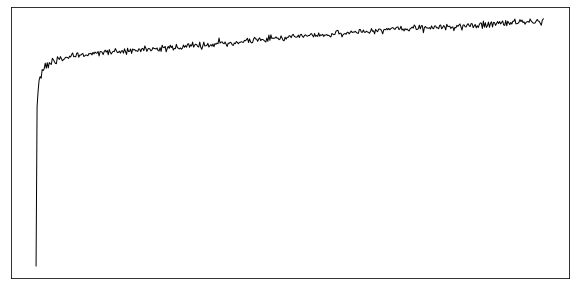

In [45]:
fig = plt.figure(figsize=(10, 5))
plt.plot(MultiInputLSTM.acc,'k',lw=1)
plt.xticks([])
plt.yticks([])
plt.show()

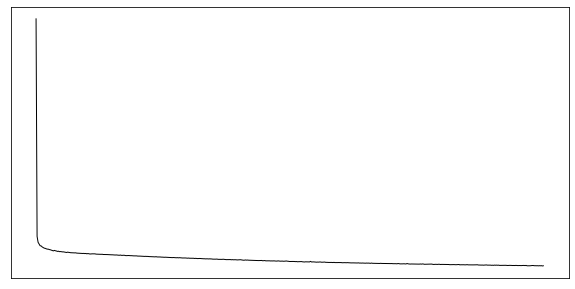

In [46]:
fig = plt.figure(figsize=(10, 5))
plt.plot(MultiInputLSTM.loss,'k',lw=1)
plt.xticks([])
plt.yticks([])
plt.show()

In [41]:
test_data[0][0:4]

array([[ 0.82295016, -0.15118027, -2.32877389, -1.25963493],
       [ 0.85752485,  0.05314967, -2.39466017, -1.10369538],
       [ 0.8900976 ,  0.24834114, -2.45642478, -0.95986732],
       [ 0.94385998,  0.33407296, -2.42425744, -1.01589748]])

In [42]:
train_data[0][0].shape

(4,)

In [43]:
len(train_data[0])

21595

In [44]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i])
    return np.array(dataX),np.array(dataY)

In [45]:
trainX,trainY=createXY(train_data[0],1)
testX,testY=createXY(test_data[0],1)

In [46]:
trainX.shape

(21594, 1, 4)

In [47]:
trainY.shape

(21594, 4)

In [48]:
testX.shape

(5398, 1, 4)

In [49]:
testY.shape

(5398, 4)

In [50]:
from tensorflow.keras.layers import Dropout

In [51]:
model = Sequential()
#input_shape千万不要写错！，第一个参数可以更改
model.add(LSTM(100,return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))  # returns a sequence of vectors of dimension 32
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(loss='mse', optimizer='adam')

print(model.summary())

history = model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), verbose=2,
                    shuffle=False)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            42000     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 32)                3232      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1

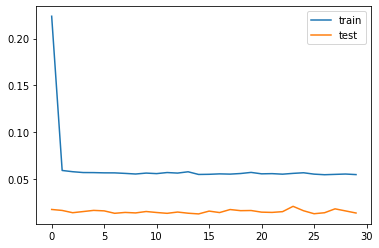

In [52]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [53]:
TESTy = model.predict(testX)

169/169 [==============================] - 1s 1ms/step


In [54]:
from math import sqrt
from sklearn.metrics import mean_squared_error

In [55]:
testY

array([[ 0.85752485,  0.05314967, -2.39466017, -1.10369538],
       [ 0.8900976 ,  0.24834114, -2.45642478, -0.95986732],
       [ 0.94385998,  0.33407296, -2.42425744, -1.01589748],
       ...,
       [ 0.39831081,  1.36835227, -0.88526799,  0.13824527],
       [ 0.47588974,  1.31666217, -0.91769927,  0.11084598],
       [ 0.51534034,  1.2822339 , -0.94379338,  0.09690129]])

Test RMSE: 0.1540468


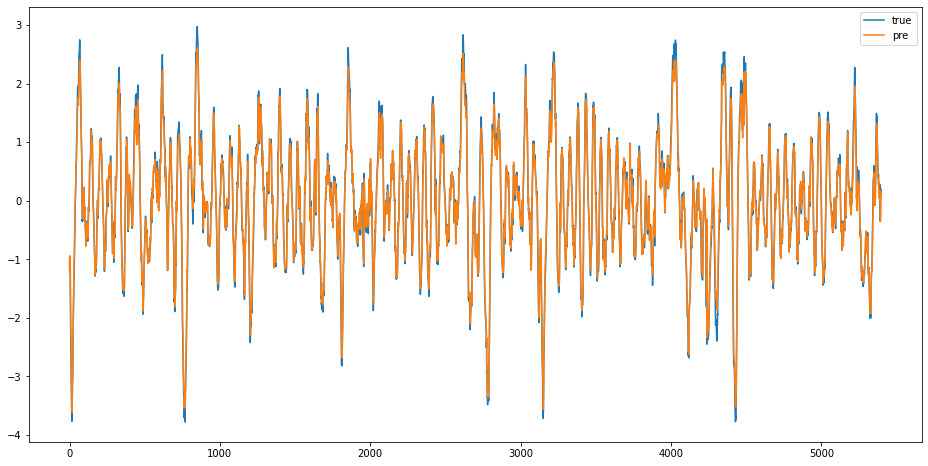

In [56]:
# 计算均方根误差
rmse = sqrt(mean_squared_error(testY[:,3], TESTy[:,3]))
print('Test RMSE: %.7f' % rmse)
#画图
plt.figure(figsize=(16,8))
plt.plot(testY[:,3], label='true')
plt.plot(TESTy[:,3], label='pre')
plt.legend()
plt.show()

In [57]:
model2 = Sequential()
#input_shape千万不要写错！，第一个参数可以更改
model2.add(LSTM(100,return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
#model.add(Dropout(0.2))
model2.add(LSTM(100, return_sequences=False))  # returns a sequence of vectors of dimension 32
#model.add(Dropout(0.2))
model2.add(Dense(32))
#model.add(Dropout(0.2))
model2.add(Dense(trainY.shape[1]))
model2.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

print(model2.summary())

history2 = model2.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), verbose=2,
                    shuffle=False)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 100)            42000     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 32)                3232      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 125,764
Trainable params: 125,764
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
338/338 - 5s - loss: 0.1843 - accuracy: 0.8757 - val_loss: 0.0129 - val_accuracy: 0.9513 - 5s/epoch - 15ms/step
Epoch 2/30
338/338 - 1s - loss: 0.0114 - accuracy: 0

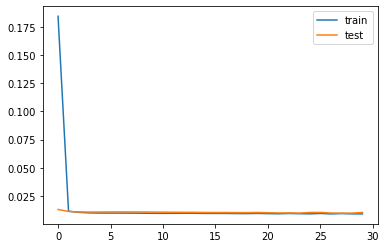

In [58]:
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

In [143]:
TESTy2 = model2.predict(testX)

169/169 [==============================] - 1s 1ms/step


Test2 RMSE: 0.1624773


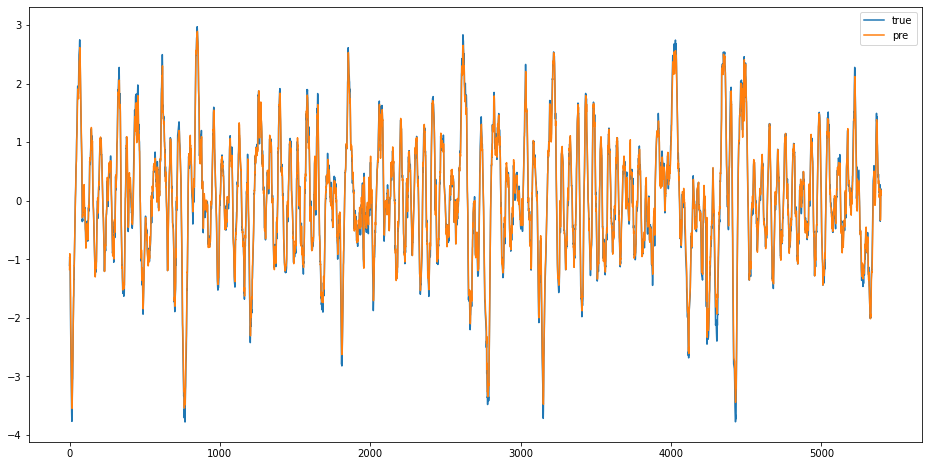

In [147]:
# 计算均方根误差
rmse2 = sqrt(mean_squared_error(testY[:,3], TESTy2[:,3]))
print('Test2 RMSE: %.7f' % rmse)
#画图
plt.figure(figsize=(16,8))
plt.plot(testY[:,3], label='true')
plt.plot(TESTy2[:,3], label='pre')
plt.legend()
plt.show()

In [150]:
model3 = Sequential()
#input_shape千万不要写错！，第一个参数可以更改
model3.add(LSTM(50,return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model3.add(Dropout(0.2))
model3.add(LSTM(50, return_sequences=False))  # returns a sequence of vectors of dimension 32
model3.add(Dropout(0.2))
model3.add(Dense(32))
model3.add(Dropout(0.2))
model3.add(Dense(trainY.shape[1]))
model3.compile(loss='mse', optimizer='adam')

print(model3.summary())

history3 = model3.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), verbose=2,
                    shuffle=False)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 1, 50)             11000     
                                                                 
 dropout_12 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_45 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_13 (Dropout)        (None, 50)                0         
                                                                 
 dense_29 (Dense)            (None, 32)                1632      
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_30 (Dense)            (None, 4)               

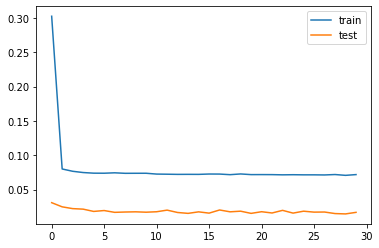

In [151]:
plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='test')
plt.legend()
plt.show()

In [156]:
model4 = Sequential()
#input_shape千万不要写错！，第一个参数可以更改
model4.add(LSTM(400,return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model4.add(Dropout(0.2))
model4.add(LSTM(400, return_sequences=False))  # returns a sequence of vectors of dimension 32
model4.add(Dropout(0.2))
model4.add(Dense(32))
model4.add(Dropout(0.2))
model4.add(Dense(trainY.shape[1]))
model4.compile(loss='mse', optimizer='adam')

print(model4.summary())

history4 = model4.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), verbose=2,
                    shuffle=False)

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 1, 400)            648000    
                                                                 
 dropout_15 (Dropout)        (None, 1, 400)            0         
                                                                 
 lstm_47 (LSTM)              (None, 400)               1281600   
                                                                 
 dropout_16 (Dropout)        (None, 400)               0         
                                                                 
 dense_31 (Dense)            (None, 32)                12832     
                                                                 
 dropout_17 (Dropout)        (None, 32)                0         
                                                                 
 dense_32 (Dense)            (None, 4)               

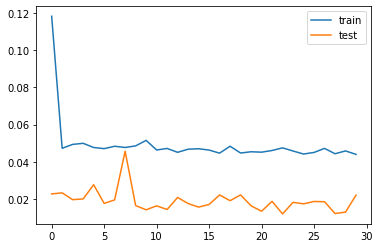

In [158]:
plt.plot(history4.history['loss'], label='train')
plt.plot(history4.history['val_loss'], label='test')
plt.legend()
plt.show()

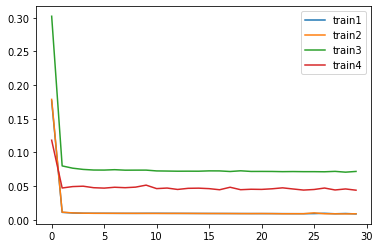

In [160]:
plt.plot(history.history['loss'], label='train1')
plt.plot(history2.history['loss'], label='train2')
plt.plot(history3.history['loss'], label='train3')
plt.plot(history4.history['loss'], label='train4')

plt.legend()
plt.show()

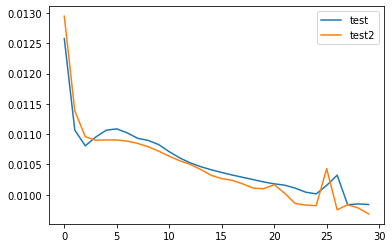

In [161]:
plt.plot(history.history['val_loss'], label='test')
plt.plot(history2.history['val_loss'], label='test2')
plt.legend()
plt.show()

In [65]:
model5 = Sequential()
#input_shape千万不要写错！，第一个参数可以更改
model5.add(LSTM(100,return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model5.add(LSTM(100, return_sequences=False))  # returns a sequence of vectors of dimension 32
model5.add(Dense(32))
model5.add(Dense(trainY.shape[1]))
model5.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

print(model5.summary())

history5 = model5.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY), verbose=2,
                    shuffle=False)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 1, 100)            42000     
                                                                 
 lstm_13 (LSTM)              (None, 100)               80400     
                                                                 
 dense_12 (Dense)            (None, 32)                3232      
                                                                 
 dense_13 (Dense)            (None, 4)                 132       
                                                                 
Total params: 125,764
Trainable params: 125,764
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
338/338 - 7s - loss: 0.1841 - accuracy: 0.8816 - val_loss: 0.0127 - val_accuracy: 0.9507 - 7s/epoch - 20ms/step
Epoch 2/100
338/338 - 1s - loss: 0.0112 - accuracy:

Epoch 60/100
338/338 - 1s - loss: 0.0086 - accuracy: 0.9544 - val_loss: 0.0093 - val_accuracy: 0.9542 - 1s/epoch - 4ms/step
Epoch 61/100
338/338 - 1s - loss: 0.0086 - accuracy: 0.9537 - val_loss: 0.0094 - val_accuracy: 0.9544 - 1s/epoch - 4ms/step
Epoch 62/100
338/338 - 1s - loss: 0.0087 - accuracy: 0.9537 - val_loss: 0.0098 - val_accuracy: 0.9522 - 1s/epoch - 4ms/step
Epoch 63/100
338/338 - 1s - loss: 0.0089 - accuracy: 0.9528 - val_loss: 0.0098 - val_accuracy: 0.9524 - 1s/epoch - 3ms/step
Epoch 64/100
338/338 - 1s - loss: 0.0086 - accuracy: 0.9533 - val_loss: 0.0094 - val_accuracy: 0.9544 - 1s/epoch - 3ms/step
Epoch 65/100
338/338 - 1s - loss: 0.0086 - accuracy: 0.9541 - val_loss: 0.0093 - val_accuracy: 0.9546 - 1s/epoch - 3ms/step
Epoch 66/100
338/338 - 1s - loss: 0.0086 - accuracy: 0.9539 - val_loss: 0.0094 - val_accuracy: 0.9539 - 1s/epoch - 4ms/step
Epoch 67/100
338/338 - 1s - loss: 0.0086 - accuracy: 0.9541 - val_loss: 0.0094 - val_accuracy: 0.9541 - 1s/epoch - 3ms/step
Epoch 68

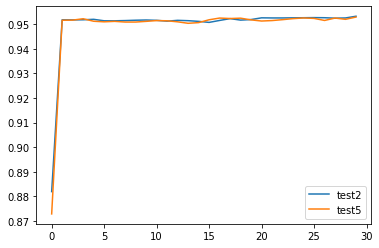

In [167]:
plt.plot(history2.history['accuracy'], label='test2')
plt.plot(history5.history['accuracy'][:30], label='test5')

plt.legend()
plt.show()

In [207]:
data_x1= testX[-1:,:]
print(data_x1.shape)
prediction = model2.predict(data_x1)
type(prediction)
prediction.shape

(1, 1, 4)
1/1 [==============================] - 0s 28ms/step


(1, 4)

In [204]:
data_x1= testX[-1:,:]
data_x1.shape

(1, 1, 4)

In [205]:
testX.shape

(5398, 1, 4)

In [226]:
time_step=30
data_x1= testX[-1:,:]
all_data

for i in range(time_step):
    prediction = model2.predict(data_x1)
    all_data.append(prediction)
    prediction = prediction.tolist()
    np.reshape(prediction, (1, 1, 4))    
    i = i+1

1/1 [==============================] - 0s 21ms/step


In [232]:
all_data[0][0].tolist()

[0.545182466506958,
 1.3005437850952148,
 -0.8852640390396118,
 0.11497776210308075]

In [239]:
final1 = []

for i in range(0,30):
    final1.append(all_data[i][0].tolist())
    i = i+1

In [242]:
final1[0]

[0.545182466506958,
 1.3005437850952148,
 -0.8852640390396118,
 0.11497776210308075]

In [ ]:
aa = all_x[worm_idx]
bb = all_y[worm_idx]
cc = all_angleArray[worm_idx]
fig1a_plane(aa,bb)

In [59]:
model6 = Sequential()
model6.add(LSTM(100,return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model6.add(LSTM(100, return_sequences=False))  # returns a sequence of vectors of dimension 32
model6.add(Dense(32))
model6.add(Dense(trainY.shape[1]))
model6.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

print(model6.summary())

history6 = model6.fit(trainX, trainY, epochs=30, batch_size=32, validation_data=(testX, testY), verbose=2,
                    shuffle=False)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 100)            42000     
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 32)                3232      
                                                                 
 dense_5 (Dense)             (None, 4)                 132       
                                                                 
Total params: 125,764
Trainable params: 125,764
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
675/675 - 5s - loss: 0.1183 - accuracy: 0.9114 - val_loss: 0.0206 - val_accuracy: 0.9478 - 5s/epoch - 8ms/step
Epoch 2/30
675/675 - 2s - loss: 0.0141 - accuracy: 0.

In [60]:
model7 = Sequential()
model7.add(LSTM(100,return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model7.add(LSTM(100, return_sequences=False))  # returns a sequence of vectors of dimension 32
model7.add(Dense(32))
model7.add(Dense(trainY.shape[1]))
model7.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

print(model7.summary())

history7 = model7.fit(trainX, trainY, epochs=30, batch_size=128, validation_data=(testX, testY), verbose=2,
                    shuffle=False)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 100)            42000     
                                                                 
 lstm_7 (LSTM)               (None, 100)               80400     
                                                                 
 dense_6 (Dense)             (None, 32)                3232      
                                                                 
 dense_7 (Dense)             (None, 4)                 132       
                                                                 
Total params: 125,764
Trainable params: 125,764
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
169/169 - 4s - loss: 0.2752 - accuracy: 0.8661 - val_loss: 0.0133 - val_accuracy: 0.9496 - 4s/epoch - 26ms/step
Epoch 2/30
169/169 - 1s - loss: 0.0109 - accuracy: 0

In [61]:
model8 = Sequential()
model8.add(LSTM(100,return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model8.add(LSTM(100, return_sequences=False))  # returns a sequence of vectors of dimension 32
model8.add(Dense(32))
model8.add(Dense(trainY.shape[1]))
model8.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

print(model8.summary())

history8 = model8.fit(trainX, trainY, epochs=30, batch_size=256, validation_data=(testX, testY), verbose=2,
                    shuffle=False)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1, 100)            42000     
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dense_8 (Dense)             (None, 32)                3232      
                                                                 
 dense_9 (Dense)             (None, 4)                 132       
                                                                 
Total params: 125,764
Trainable params: 125,764
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
85/85 - 5s - loss: 0.4751 - accuracy: 0.8174 - val_loss: 0.0542 - val_accuracy: 0.9363 - 5s/epoch - 53ms/step
Epoch 2/30
85/85 - 1s - loss: 0.0150 - accuracy: 0.949

In [62]:
model9 = Sequential()
model9.add(LSTM(100,return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model9.add(LSTM(100, return_sequences=False))  # returns a sequence of vectors of dimension 32
model9.add(Dense(32))
model9.add(Dense(trainY.shape[1]))
model9.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

print(model9.summary())

history9 = model9.fit(trainX, trainY, epochs=200, batch_size=64, validation_data=(testX, testY), verbose=2,
                    shuffle=False)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 1, 100)            42000     
                                                                 
 lstm_11 (LSTM)              (None, 100)               80400     
                                                                 
 dense_10 (Dense)            (None, 32)                3232      
                                                                 
 dense_11 (Dense)            (None, 4)                 132       
                                                                 
Total params: 125,764
Trainable params: 125,764
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
338/338 - 6s - loss: 0.1801 - accuracy: 0.8921 - val_loss: 0.0129 - val_accuracy: 0.9537 - 6s/epoch - 17ms/step
Epoch 2/200
338/338 - 1s - loss: 0.0115 - accuracy:

Epoch 60/200
338/338 - 1s - loss: 0.0087 - accuracy: 0.9541 - val_loss: 0.0092 - val_accuracy: 0.9546 - 1s/epoch - 3ms/step
Epoch 61/200
338/338 - 1s - loss: 0.0086 - accuracy: 0.9543 - val_loss: 0.0096 - val_accuracy: 0.9528 - 1s/epoch - 3ms/step
Epoch 62/200
338/338 - 1s - loss: 0.0086 - accuracy: 0.9536 - val_loss: 0.0093 - val_accuracy: 0.9537 - 1s/epoch - 3ms/step
Epoch 63/200
338/338 - 1s - loss: 0.0086 - accuracy: 0.9540 - val_loss: 0.0092 - val_accuracy: 0.9552 - 1s/epoch - 3ms/step
Epoch 64/200
338/338 - 1s - loss: 0.0085 - accuracy: 0.9543 - val_loss: 0.0093 - val_accuracy: 0.9541 - 1s/epoch - 3ms/step
Epoch 65/200
338/338 - 1s - loss: 0.0086 - accuracy: 0.9539 - val_loss: 0.0092 - val_accuracy: 0.9552 - 1s/epoch - 3ms/step
Epoch 66/200
338/338 - 1s - loss: 0.0085 - accuracy: 0.9540 - val_loss: 0.0092 - val_accuracy: 0.9554 - 1s/epoch - 3ms/step
Epoch 67/200
338/338 - 1s - loss: 0.0086 - accuracy: 0.9543 - val_loss: 0.0093 - val_accuracy: 0.9541 - 1s/epoch - 4ms/step
Epoch 68

Epoch 126/200
338/338 - 1s - loss: 0.0081 - accuracy: 0.9556 - val_loss: 0.0092 - val_accuracy: 0.9570 - 1s/epoch - 3ms/step
Epoch 127/200
338/338 - 1s - loss: 0.0081 - accuracy: 0.9548 - val_loss: 0.0090 - val_accuracy: 0.9576 - 1s/epoch - 3ms/step
Epoch 128/200
338/338 - 1s - loss: 0.0081 - accuracy: 0.9556 - val_loss: 0.0092 - val_accuracy: 0.9576 - 1s/epoch - 3ms/step
Epoch 129/200
338/338 - 1s - loss: 0.0081 - accuracy: 0.9548 - val_loss: 0.0090 - val_accuracy: 0.9579 - 1s/epoch - 3ms/step
Epoch 130/200
338/338 - 1s - loss: 0.0081 - accuracy: 0.9556 - val_loss: 0.0092 - val_accuracy: 0.9574 - 1s/epoch - 3ms/step
Epoch 131/200
338/338 - 1s - loss: 0.0081 - accuracy: 0.9551 - val_loss: 0.0090 - val_accuracy: 0.9579 - 1s/epoch - 3ms/step
Epoch 132/200
338/338 - 1s - loss: 0.0081 - accuracy: 0.9557 - val_loss: 0.0092 - val_accuracy: 0.9572 - 1s/epoch - 3ms/step
Epoch 133/200
338/338 - 1s - loss: 0.0081 - accuracy: 0.9550 - val_loss: 0.0090 - val_accuracy: 0.9576 - 1s/epoch - 3ms/step


Epoch 192/200
338/338 - 1s - loss: 0.0078 - accuracy: 0.9566 - val_loss: 0.0090 - val_accuracy: 0.9554 - 1s/epoch - 3ms/step
Epoch 193/200
338/338 - 1s - loss: 0.0078 - accuracy: 0.9567 - val_loss: 0.0090 - val_accuracy: 0.9555 - 1s/epoch - 3ms/step
Epoch 194/200
338/338 - 1s - loss: 0.0078 - accuracy: 0.9566 - val_loss: 0.0090 - val_accuracy: 0.9555 - 1s/epoch - 3ms/step
Epoch 195/200
338/338 - 1s - loss: 0.0078 - accuracy: 0.9566 - val_loss: 0.0090 - val_accuracy: 0.9557 - 1s/epoch - 3ms/step
Epoch 196/200
338/338 - 1s - loss: 0.0078 - accuracy: 0.9567 - val_loss: 0.0090 - val_accuracy: 0.9557 - 1s/epoch - 3ms/step
Epoch 197/200
338/338 - 1s - loss: 0.0078 - accuracy: 0.9567 - val_loss: 0.0090 - val_accuracy: 0.9557 - 1s/epoch - 3ms/step
Epoch 198/200
338/338 - 1s - loss: 0.0078 - accuracy: 0.9568 - val_loss: 0.0090 - val_accuracy: 0.9557 - 1s/epoch - 3ms/step
Epoch 199/200
338/338 - 1s - loss: 0.0078 - accuracy: 0.9568 - val_loss: 0.0090 - val_accuracy: 0.9557 - 1s/epoch - 3ms/step


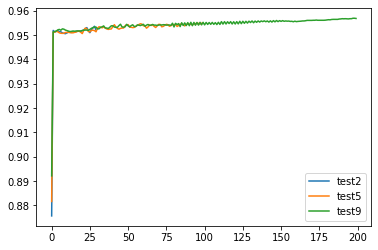

In [66]:
plt.plot(history2.history['accuracy'], label='test2')
plt.plot(history5.history['accuracy'], label='test5')
plt.plot(history9.history['accuracy'], label='test9')

plt.legend()
plt.show()

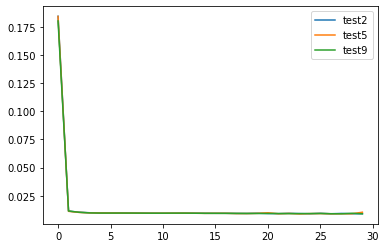

In [69]:
plt.plot(history2.history['loss'], label='test2')
plt.plot(history5.history['loss'][:30], label='test5')
plt.plot(history9.history['loss'][:30], label='test9')

plt.legend()
plt.show()

In [51]:
model10 = Sequential()
model10.add(LSTM(100,return_sequences=False, input_shape=(trainX.shape[1], trainX.shape[2])))
#model9.add(LSTM(100, return_sequences=False))  # returns a sequence of vectors of dimension 32
model10.add(Dense(32))
model10.add(Dense(trainY.shape[1]))
model10.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

print(model10.summary())

history10 = model10.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), verbose=2,
                    shuffle=False)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               42000     
                                                                 
 dense (Dense)               (None, 32)                3232      
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 45,364
Trainable params: 45,364
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
338/338 - 4s - loss: 0.1843 - accuracy: 0.8655 - val_loss: 0.0112 - val_accuracy: 0.9505 - 4s/epoch - 11ms/step
Epoch 2/200
338/338 - 1s - loss: 0.0097 - accuracy: 0.9522 - val_loss: 0.0106 - val_accuracy: 0.9505 - 947ms/epoch - 3ms/step
Epoch 3/200
338/338 - 1s - loss: 0.0095 - accuracy: 0.9525 

KeyboardInterrupt: 

In [53]:
model11 = Sequential()
model11.add(LSTM(100,return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model11.add(LSTM(100, return_sequences=True))  # returns a sequence of vectors of dimension 32
model11.add(LSTM(100, return_sequences=False))
model11.add(Dense(32))
model11.add(Dense(trainY.shape[1]))
model11.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

print(model11.summary())

history11 = model11.fit(trainX, trainY, epochs=200, batch_size=64, validation_data=(testX, testY), verbose=2,
                    shuffle=False)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 100)            42000     
                                                                 
 lstm_4 (LSTM)               (None, 1, 100)            80400     
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 32)                3232      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 206,164
Trainable params: 206,164
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
338/338 - 31s - loss: 0.2200 - 

KeyboardInterrupt: 